# 导入工具

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import json
TEMP_FOLDER = os.path.abspath('./temp/')
print(f"文件夹 '{TEMP_FOLDER}' 将被用来存储语料和临时性字典")
import logging
logging.basicConfig(format="%(asctime)s: %(levelname)s: %(message)s", level=logging.INFO)
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import seaborn
seaborn.set()
import matplotlib.pyplot as  plt
import matplotlib.patches as patches
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline

import jieba
# 基于textrank和tfidf的关键词提取
from jieba.analyse import textrank
from jieba.analyse import extract_tags

# 分句不需要额外模型
from pyltp import SentenceSplitter

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from gensim import corpora, similarities, models, matutils
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from textrank4zh import TextRank4Keyword, TextRank4Sentence

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from keras.preprocessing import sequence
from keras.preprocessing import text

from optparse import OptionParser

import networkx as nx

from tqdm import tqdm

import pyLDAvis.gensim
CAN_VISUALIZE = True
pyLDAvis.enable_notebook()

from collections import Counter, defaultdict
from itertools import combinations
from smart_open import smart_open
from six import iteritems

文件夹 'D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp' 将被用来存储语料和临时性字典


2019-10-24 21:02:23,913: INFO: 'pattern' package not found; tag filters are not available for English
Using TensorFlow backend.


## 加载停用词

In [2]:
def fetch_stopwords(path):
    stopwords = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.append(line.strip())
    return stopwords

stopwords = fetch_stopwords('data/stopwords.txt')
stopwords[:10]

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

# 语料，向量空间和模型

In [11]:
raw_corpus = ['商业新知:知识图谱为内核,构建商业创新服务完整生态。',
'如何更好利用知识图谱技术做反欺诈? 360金融首席数据科学家沈赟开讲。',
'知识管理 | 基于知识图谱的国际知识管理领域可视化分析。',
'一文详解达观数据知识图谱技术与应用。',
'知识图谱技术落地金融行业的关键四步。',
'一文读懂知识图谱的商业应用进程及技术背景。',
'海云数据CPO王斌:打造大数据可视分析与AI应用的高科技企业。',
'智能产业|《人工智能标准化白皮书2018》带来创新创业新技术标准。',
'国家语委重大科研项目“中华经典诗词知识图谱构建技术研究”开题。',
'最全知识图谱介绍:关键技术、开放数据集、应用案例汇总。',
'中译语通Jove Mind知识图谱平台 引领企业智能化发展。',
'知识图谱:知识图谱赋能企业数字化转型，为企业升级转型注入新能量。']
jieba.add_word('知识图谱')

Building prefix dict from the default dictionary ...
2019-10-22 13:05:43,816: DEBUG: Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
2019-10-22 13:05:43,823: DEBUG: Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.803 seconds.
2019-10-22 13:05:44,621: DEBUG: Loading model cost 0.803 seconds.
Prefix dict has been built succesfully.
2019-10-22 13:05:44,623: DEBUG: Prefix dict has been built succesfully.


In [12]:
raw_corpus = [' '.join(jieba.lcut(i)) for i in raw_corpus]
raw_corpus

['商业 新知 : 知识图谱 为 内核 , 构建 商业 创新 服务 完整 生态 。',
 '如何 更好 利用 知识图谱 技术 做 反 欺诈 ?   360 金融 首席 数据 科学家 沈赟 开讲 。',
 '知识 管理   |   基于 知识图谱 的 国际 知识 管理 领域 可视化 分析 。',
 '一文 详解 达观 数据 知识图谱 技术 与 应用 。',
 '知识图谱 技术 落地 金融 行业 的 关键 四步 。',
 '一文 读懂 知识图谱 的 商业 应用 进程 及 技术 背景 。',
 '海云 数据 CPO 王斌 : 打造 大 数据 可视 分析 与 AI 应用 的 高科技 企业 。',
 '智能 产业 | 《 人工智能 标准化 白皮书 2018 》 带来 创新 创业 新 技术标准 。',
 '国家语委 重大 科研项目 “ 中华 经典 诗词 知识图谱 构建 技术 研究 ” 开题 。',
 '最全 知识图谱 介绍 : 关键技术 、 开放 数据 集 、 应用 案例 汇总 。',
 '中译 语通 Jove   Mind 知识图谱 平台   引领 企业 智能化 发展 。',
 '知识图谱 : 知识图谱 赋能 企业 数字化 转型 ， 为 企业 升级 转型 注入 新 能量 。']

In [14]:
def substract_stopwords(stopwords:list, raw_data:list):
    return [[word for word in doc.lower().split() if word not in stopwords] for doc in raw_data]

# 去除停用词
texts = substract_stopwords(stopwords, raw_corpus)
# 统计词频
token_counter = Counter([word for text in texts for word in text])
# 只保留词频大于1的词汇
processed_texts = [[word for word in text if token_counter[word] > 1] for text in texts]
processed_texts

[['商业', '知识图谱', '构建', '商业', '创新'],
 ['知识图谱', '技术', '金融', '数据'],
 ['知识', '管理', '知识图谱', '知识', '管理', '分析'],
 ['一文', '数据', '知识图谱', '技术'],
 ['知识图谱', '技术', '金融'],
 ['一文', '知识图谱', '商业', '技术'],
 ['数据', '数据', '分析', '企业'],
 ['创新', '新'],
 ['知识图谱', '构建', '技术'],
 ['知识图谱', '数据'],
 ['知识图谱', '企业'],
 ['知识图谱', '知识图谱', '企业', '转型', '企业', '转型', '新']]

In [15]:
# 词汇到id的映射
dictionary = corpora.Dictionary(processed_texts)
print(dictionary)

2019-10-22 13:05:47,515: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-22 13:05:47,517: INFO: built Dictionary(14 unique tokens: ['创新', '商业', '构建', '知识图谱', '技术']...) from 12 documents (total 46 corpus positions)


Dictionary(14 unique tokens: ['创新', '商业', '构建', '知识图谱', '技术']...)


In [16]:
print(dictionary.token2id)

{'创新': 0, '商业': 1, '构建': 2, '知识图谱': 3, '技术': 4, '数据': 5, '金融': 6, '分析': 7, '知识': 8, '管理': 9, '一文': 10, '企业': 11, '新': 12, '转型': 13}


In [17]:
new_doc = '知识图谱 为 企业 转型 助力'
new_doc = dictionary.doc2bow(new_doc.lower().split())
new_doc

[(3, 1), (11, 1), (13, 1)]

In [18]:
# (a,b) a为词汇在字典中索引，b为该词汇在该句中的出现次数
bow_texts = [dictionary.doc2bow(text) for text in processed_texts]
bow_texts

[[(0, 1), (1, 2), (2, 1), (3, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1)],
 [(3, 1), (7, 1), (8, 2), (9, 2)],
 [(3, 1), (4, 1), (5, 1), (10, 1)],
 [(3, 1), (4, 1), (6, 1)],
 [(1, 1), (3, 1), (4, 1), (10, 1)],
 [(5, 2), (7, 1), (11, 1)],
 [(0, 1), (12, 1)],
 [(2, 1), (3, 1), (4, 1)],
 [(3, 1), (5, 1)],
 [(3, 1), (11, 1)],
 [(3, 2), (11, 2), (12, 1), (13, 2)]]

In [19]:
# (a, b) a为词汇索引，b为该词汇的tfidf权重，与文档中出现的次数成正比，与语料库中的出现次数成反比
tfidf = models.TfidfModel(bow_texts)
tfidf[new_doc]

2019-10-22 13:05:50,044: INFO: collecting document frequencies
2019-10-22 13:05:50,045: INFO: PROGRESS: processing document #0
2019-10-22 13:05:50,047: INFO: calculating IDF weights for 12 documents and 14 features (39 matrix non-zeros)


[(3, 0.06394369208554566), (11, 0.4862002131078655), (13, 0.8715047659171663)]

# 语料库和词向量空间

In [81]:
# 构建语料库流，即文件生成器，将语料逐个从硬盘中读取处理后传入模型
class MyCorpus:
    def __init__(self, path):
        self.path = path
        
    def __iter__(self):
        for line in smart_open(self.path, 'r', encoding='utf-8'):
            yield dictionary.doc2bow(' '.join(jieba.lcut(line)).lower().split())

In [91]:
news_corpus = iter(MyCorpus('data/corpus.txt'))

next(news_corpus)

In [111]:
class MyCorpus2:
    def __init__(self, path):
        self.path = path
        self.dict = None
        
    def get_dictionary(self):
        self.dict = corpora.Dictionary(' '.join(jieba.lcut(line)).lower().split()
                                      for line in smart_open(self.path, 'r', encoding='utf-8'))
        return self.dict
    
    def sub_stopword(self, stoplist):
        self.get_dictionary()
        stop_ids = [self.dict.token2id[stopword] for stopword in stoplist
                   if stopword in self.dict.token2id]
        once_ids = [tokenid for tokenid, wordfreq in self.dict.dfs.items()
                   if wordfreq == 1]
        self.dict.filter_tokens(stop_ids + once_ids)
        return self.dict

In [112]:
corpus = MyCorpus2('data/corpus_short.txt')

In [113]:
print(corpus.get_dictionary())

2019-10-22 13:48:04,363: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-22 13:48:04,367: INFO: built Dictionary(103 unique tokens: [':', '。', '为', '内核', '创新']...) from 12 documents (total 159 corpus positions)


Dictionary(103 unique tokens: [':', '。', '为', '内核', '创新']...)


In [114]:
print(corpus.sub_stopword(stopwords))

2019-10-22 13:48:05,254: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-22 13:48:05,258: INFO: built Dictionary(103 unique tokens: [':', '。', '为', '内核', '创新']...) from 12 documents (total 159 corpus positions)


Dictionary(11 unique tokens: ['创新', '商业', '构建', '知识图谱', '技术']...)


# 主题模型与文本数据转换

In [124]:
tfidf = models.TfidfModel(bow_texts)
print(tfidf)

2019-10-22 14:03:43,408: INFO: collecting document frequencies
2019-10-22 14:03:43,409: INFO: PROGRESS: processing document #0
2019-10-22 14:03:43,410: INFO: calculating IDF weights for 12 documents and 14 features (39 matrix non-zeros)


TfidfModel(num_docs=12, num_nnz=39)


In [126]:
corpus_tfidf = tfidf[bow_texts]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.4078964886286983), (1, 0.8157929772573966), (2, 0.4078964886286983), (3, 0.04150575124328046)]
[(3, 0.07982263066186342), (4, 0.38329103210095783), (5, 0.48098603643475885), (6, 0.7844544378738532)]
[(3, 0.025128868703899597), (7, 0.24695318119778994), (8, 0.6849754251993109), (9, 0.6849754251993109)]
[(3, 0.07982263066186342), (4, 0.38329103210095783), (5, 0.48098603643475885), (10, 0.7844544378738532)]
[(3, 0.0910460341905888), (4, 0.43718339178067905), (6, 0.8947520894690928)]
[(1, 0.6668011702142979), (3, 0.06785075201967737), (4, 0.32580465658435587), (10, 0.6668011702142979)]
[(5, 0.6962169034343767), (7, 0.5677404313752555), (11, 0.4392639593161345)]
[(0, 0.7071067811865476), (12, 0.7071067811865476)]
[(2, 0.8947520894690927), (3, 0.09104603419058879), (4, 0.437183391780679)]
[(3, 0.16371704169295062), (5, 0.9865073391816752)]
[(3, 0.13039433685974838), (11, 0.9914622115415728)]
[(3, 0.061003335283038695), (11, 0.4638430101162164), (12, 0.29975419684301086), (13, 0.831429

In [248]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5)
lsi.show_topics()

2019-10-23 00:07:49,105: INFO: using serial LSI version on this node
2019-10-23 00:07:49,108: INFO: updating model with new documents
2019-10-23 00:07:49,116: INFO: preparing a new chunk of documents
2019-10-23 00:07:49,122: INFO: using 100 extra samples and 2 power iterations
2019-10-23 00:07:49,123: INFO: 1st phase: constructing (14, 105) action matrix
2019-10-23 00:07:49,139: INFO: orthonormalizing (14, 105) action matrix
2019-10-23 00:07:49,150: INFO: 2nd phase: running dense svd on (14, 12) matrix
2019-10-23 00:07:49,153: INFO: computing the final decomposition
2019-10-23 00:07:49,156: INFO: keeping 5 factors (discarding 27.373% of energy spectrum)
2019-10-23 00:07:49,157: INFO: processed documents up to #12
2019-10-23 00:07:49,161: INFO: topic #0(1.667): 0.663*"数据" + 0.402*"金融" + 0.402*"技术" + 0.322*"一文" + 0.201*"企业" + 0.180*"商业" + 0.141*"知识图谱" + 0.133*"分析" + 0.132*"构建" + 0.047*"创新"
2019-10-23 00:07:49,163: INFO: topic #1(1.363): 0.507*"企业" + -0.463*"商业" + 0.382*"数据" + -0.331*"构建"

[(0,
  '0.663*"数据" + 0.402*"金融" + 0.402*"技术" + 0.322*"一文" + 0.201*"企业" + 0.180*"商业" + 0.141*"知识图谱" + 0.133*"分析" + 0.132*"构建" + 0.047*"创新"'),
 (1,
  '0.507*"企业" + -0.463*"商业" + 0.382*"数据" + -0.331*"构建" + -0.294*"技术" + -0.266*"一文" + 0.196*"分析" + 0.173*"转型" + -0.165*"创新" + -0.131*"金融"'),
 (2,
  '0.492*"企业" + -0.465*"金融" + 0.424*"商业" + 0.322*"创新" + 0.279*"新" + 0.271*"转型" + 0.227*"构建" + 0.157*"一文" + -0.114*"数据" + -0.108*"技术"'),
 (3,
  '-0.604*"金融" + 0.411*"数据" + 0.370*"一文" + -0.324*"企业" + -0.271*"转型" + -0.232*"新" + -0.178*"技术" + -0.136*"创新" + -0.132*"构建" + 0.128*"商业"'),
 (4,
  '0.531*"创新" + 0.395*"新" + -0.382*"一文" + -0.372*"企业" + 0.293*"数据" + 0.235*"管理" + 0.235*"知识" + -0.167*"技术" + 0.154*"分析" + -0.131*"转型"')]

In [251]:
lsi.get_topics()

array([[ 0.04696711,  0.18049842,  0.13192449,  0.140966  ,  0.40227199,
         0.66275141,  0.40242581,  0.13252469,  0.0134947 ,  0.0134947 ,
         0.32212849,  0.20102439,  0.02968701,  0.04409437],
       [-0.16487302, -0.46286969, -0.33122749,  0.00854011, -0.29371629,
         0.38187076, -0.13062953,  0.19627343,  0.03621869,  0.03621869,
        -0.26643894,  0.50689427,  0.02467565,  0.17302626],
       [ 0.32193386,  0.42433544,  0.22658317,  0.04055029, -0.10829845,
        -0.11406799, -0.46480035,  0.06547929,  0.01638055,  0.01638055,
         0.15726152,  0.49202822,  0.27876897,  0.2705089 ],
       [-0.13591551,  0.12796102, -0.13195354, -0.03932863, -0.17792191,
         0.41095293, -0.60400667,  0.09421154,  0.03515782,  0.03515782,
         0.36988661, -0.32440787, -0.23184189, -0.27143452],
       [ 0.53078856, -0.03545908,  0.10209456, -0.02876644, -0.16742799,
         0.29279486,  0.02577203,  0.15411137,  0.23506537,  0.23506537,
        -0.38170744, -0.37

In [132]:
corpus_lsi = lsi[bow_texts]
for doc in corpus_lsi:
    print(doc)

[(0, -0.6808544530209414), (1, -1.4132997962625367), (2, 1.4377382033464805)]
[(0, -1.6084152082638636), (1, -0.03393495171428909), (2, -0.6466164998759968)]
[(0, -0.3274694713634696), (1, 0.3496882927774646), (2, 0.1715517956047342)]
[(0, -1.5281178945235512), (1, -0.16974436066268872), (2, -0.024554631915174957)]
[(0, -0.9456637976705571), (1, -0.41580571151717216), (2, -0.5325485141558044)]
[(0, -1.0458649077610795), (1, -1.014484815434284), (2, 0.5138487927852903)]
[(0, -1.6590518963679135), (1, 1.4669092192837978), (2, 0.3293715394745137)]
[(0, -0.07665411819713507), (1, -0.14019736963550833), (2, 0.6007028354587611)]
[(0, -0.6751624816501721), (1, -0.6164036717920012), (2, 0.1588350098001967)]
[(0, -0.8037174124871265), (1, 0.3904108719394301), (2, -0.0735176950171789)]
[(0, -0.3419903882423803), (1, 0.5154343827840457), (2, 0.5325785071905051)]
[(0, -0.8018565231400958), (1, 1.40159694938736), (2, 1.8849437783977594)]


In [146]:
lsi.save(os.path.join(TEMP_FOLDER, 'model.lsi'))

2019-10-22 14:20:28,458: INFO: saving Projection object under D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi.projection, separately None
2019-10-22 14:20:28,461: INFO: saved D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi.projection
2019-10-22 14:20:28,462: INFO: saving LsiModel object under D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi, separately None
2019-10-22 14:20:28,462: INFO: not storing attribute projection
2019-10-22 14:20:28,463: INFO: not storing attribute dispatcher
2019-10-22 14:20:28,466: INFO: saved D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi


In [147]:
lsi = models.LsiModel.load(os.path.join(TEMP_FOLDER, 'model.lsi'))

2019-10-22 14:21:13,705: INFO: loading LsiModel object from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi
2019-10-22 14:21:13,712: INFO: loading id2word recursively from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi.id2word.* with mmap=None
2019-10-22 14:21:13,713: INFO: setting ignored attribute projection to None
2019-10-22 14:21:13,713: INFO: setting ignored attribute dispatcher to None
2019-10-22 14:21:13,714: INFO: loaded D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi
2019-10-22 14:21:13,715: INFO: loading LsiModel object from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi.projection
2019-10-22 14:21:13,723: INFO: loaded D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\model.lsi.projection


In [149]:
lsi.show_topics()

[(0,
  '-0.663*"数据" + -0.402*"金融" + -0.402*"技术" + -0.322*"一文" + -0.201*"企业" + -0.180*"商业" + -0.141*"知识图谱" + -0.133*"分析" + -0.132*"构建" + -0.047*"创新"'),
 (1,
  '0.507*"企业" + -0.463*"商业" + 0.382*"数据" + -0.331*"构建" + -0.294*"技术" + -0.266*"一文" + 0.196*"分析" + 0.173*"转型" + -0.165*"创新" + -0.131*"金融"'),
 (2,
  '0.492*"企业" + -0.465*"金融" + 0.424*"商业" + 0.322*"创新" + 0.279*"新" + 0.271*"转型" + 0.227*"构建" + 0.157*"一文" + -0.114*"数据" + -0.108*"技术"')]

In [150]:
lsi.print_topics()

2019-10-22 14:22:57,615: INFO: topic #0(1.667): -0.663*"数据" + -0.402*"金融" + -0.402*"技术" + -0.322*"一文" + -0.201*"企业" + -0.180*"商业" + -0.141*"知识图谱" + -0.133*"分析" + -0.132*"构建" + -0.047*"创新"
2019-10-22 14:22:57,617: INFO: topic #1(1.363): 0.507*"企业" + -0.463*"商业" + 0.382*"数据" + -0.331*"构建" + -0.294*"技术" + -0.266*"一文" + 0.196*"分析" + 0.173*"转型" + -0.165*"创新" + -0.131*"金融"
2019-10-22 14:22:57,618: INFO: topic #2(1.287): 0.492*"企业" + -0.465*"金融" + 0.424*"商业" + 0.322*"创新" + 0.279*"新" + 0.271*"转型" + 0.227*"构建" + 0.157*"一文" + -0.114*"数据" + -0.108*"技术"


[(0,
  '-0.663*"数据" + -0.402*"金融" + -0.402*"技术" + -0.322*"一文" + -0.201*"企业" + -0.180*"商业" + -0.141*"知识图谱" + -0.133*"分析" + -0.132*"构建" + -0.047*"创新"'),
 (1,
  '0.507*"企业" + -0.463*"商业" + 0.382*"数据" + -0.331*"构建" + -0.294*"技术" + -0.266*"一文" + 0.196*"分析" + 0.173*"转型" + -0.165*"创新" + -0.131*"金融"'),
 (2,
  '0.492*"企业" + -0.465*"金融" + 0.424*"商业" + 0.322*"创新" + 0.279*"新" + 0.271*"转型" + 0.227*"构建" + 0.157*"一文" + -0.114*"数据" + -0.108*"技术"')]

In [158]:
# LSI的增量学习
new_doc = ' '.join(jieba.lcut('知识图谱的商业应用前景非常广阔'))
new_doc = dictionary.doc2bow(new_doc.lower().split())
new_doc_vec = tfidf[new_doc]
print(new_doc_vec)
lsi.add_documents([new_doc_vec])
lsi_vec = lsi[new_doc_vec]

2019-10-22 14:45:49,810: INFO: updating model with new documents
2019-10-22 14:45:49,811: INFO: preparing a new chunk of documents
2019-10-22 14:45:49,812: INFO: using 100 extra samples and 2 power iterations
2019-10-22 14:45:49,812: INFO: 1st phase: constructing (14, 103) action matrix
2019-10-22 14:45:49,814: INFO: orthonormalizing (14, 103) action matrix
2019-10-22 14:45:49,816: INFO: 2nd phase: running dense svd on (14, 1) matrix
2019-10-22 14:45:49,816: INFO: computing the final decomposition
2019-10-22 14:45:49,817: INFO: keeping 1 factors (discarding 0.000% of energy spectrum)
2019-10-22 14:45:49,818: INFO: merging projections: (14, 3) + (14, 1)
2019-10-22 14:45:49,819: INFO: keeping 3 factors (discarding 2.947% of energy spectrum)
2019-10-22 14:45:49,820: INFO: processed documents up to #1
2019-10-22 14:45:49,821: INFO: topic #0(1.815): 0.817*"商业" + 0.293*"一文" + 0.282*"技术" + 0.228*"构建" + 0.206*"数据" + 0.152*"创新" + 0.147*"金融" + 0.130*"知识图谱" + 0.073*"新" + 0.061*"企业"
2019-10-22 14:

[(1, 0.9948627588855407), (3, 0.10123285525287981)]


In [161]:
lda_model = models.LdaModel(bow_texts, id2word=dictionary, num_topics=3)
lda_model.print_topics()

2019-10-22 14:49:32,112: INFO: using symmetric alpha at 0.3333333333333333
2019-10-22 14:49:32,113: INFO: using symmetric eta at 0.3333333333333333
2019-10-22 14:49:32,114: INFO: using serial LDA version on this node
2019-10-22 14:49:32,114: INFO: running online (single-pass) LDA training, 3 topics, 1 passes over the supplied corpus of 12 documents, updating model once every 12 documents, evaluating perplexity every 12 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-22 14:49:32,115: WARNING: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-22 14:49:32,141: INFO: -3.829 per-word bound, 14.2 perplexity estimate based on a held-out corpus of 12 documents with 46 words
2019-10-22 14:49:32,142: INFO: PROGRESS: pass 0, at document #12/12
2019-10-22 14:49:32,166: INFO: topic #0 (0.333): 0.233*"知识图谱" + 0.173*"企业" + 0.122*"转型" + 0.119*"新" + 0.076*"技术" + 0.069*"构建" + 0.064*"创新" + 0.026*"数据" 

[(0,
  '0.233*"知识图谱" + 0.173*"企业" + 0.122*"转型" + 0.119*"新" + 0.076*"技术" + 0.069*"构建" + 0.064*"创新" + 0.026*"数据" + 0.021*"商业" + 0.020*"金融"'),
 (1,
  '0.184*"知识图谱" + 0.175*"数据" + 0.137*"商业" + 0.097*"技术" + 0.096*"一文" + 0.058*"创新" + 0.057*"企业" + 0.057*"构建" + 0.057*"分析" + 0.017*"知识"'),
 (2,
  '0.187*"知识图谱" + 0.129*"技术" + 0.126*"管理" + 0.126*"金融" + 0.125*"知识" + 0.079*"数据" + 0.073*"分析" + 0.025*"创新" + 0.024*"企业" + 0.022*"商业"')]

In [162]:
# 层次狄利克雷过程，不需要设定主题数目
hdp_model = models.HdpModel(bow_texts, id2word=dictionary)
hdp_model.show_topics()

2019-10-22 14:52:56,880: INFO: (0, '0.148*管理 + 0.135*构建 + 0.126*转型 + 0.104*知识 + 0.087*创新 + 0.079*分析 + 0.056*新 + 0.051*企业 + 0.051*知识图谱 + 0.050*一文')
2019-10-22 14:52:56,881: INFO: (1, '0.300*知识 + 0.139*转型 + 0.138*商业 + 0.111*企业 + 0.090*分析 + 0.059*知识图谱 + 0.040*管理 + 0.032*创新 + 0.028*金融 + 0.027*一文')
2019-10-22 14:52:56,882: INFO: (2, '0.308*分析 + 0.174*知识图谱 + 0.141*创新 + 0.075*商业 + 0.056*一文 + 0.054*管理 + 0.054*构建 + 0.042*企业 + 0.036*知识 + 0.027*数据')
2019-10-22 14:52:56,883: INFO: (3, '0.310*管理 + 0.263*企业 + 0.112*转型 + 0.088*一文 + 0.069*分析 + 0.038*技术 + 0.027*商业 + 0.027*知识 + 0.023*创新 + 0.018*构建')
2019-10-22 14:52:56,884: INFO: (4, '0.181*新 + 0.152*创新 + 0.148*商业 + 0.104*技术 + 0.095*转型 + 0.084*构建 + 0.046*一文 + 0.044*知识 + 0.038*金融 + 0.034*管理')
2019-10-22 14:52:56,885: INFO: (5, '0.269*金融 + 0.148*数据 + 0.107*一文 + 0.083*知识图谱 + 0.072*企业 + 0.057*分析 + 0.052*管理 + 0.050*构建 + 0.045*转型 + 0.042*商业')
2019-10-22 14:52:56,888: INFO: (6, '0.269*知识 + 0.233*企业 + 0.155*分析 + 0.094*数据 + 0.071*构建 + 0.054*管理 + 0.042*知识图谱 + 0.0

[(0,
  '0.148*管理 + 0.135*构建 + 0.126*转型 + 0.104*知识 + 0.087*创新 + 0.079*分析 + 0.056*新 + 0.051*企业 + 0.051*知识图谱 + 0.050*一文 + 0.046*商业 + 0.031*数据 + 0.027*技术 + 0.009*金融'),
 (1,
  '0.300*知识 + 0.139*转型 + 0.138*商业 + 0.111*企业 + 0.090*分析 + 0.059*知识图谱 + 0.040*管理 + 0.032*创新 + 0.028*金融 + 0.027*一文 + 0.018*构建 + 0.013*技术 + 0.005*新 + 0.001*数据'),
 (2,
  '0.308*分析 + 0.174*知识图谱 + 0.141*创新 + 0.075*商业 + 0.056*一文 + 0.054*管理 + 0.054*构建 + 0.042*企业 + 0.036*知识 + 0.027*数据 + 0.014*金融 + 0.009*新 + 0.007*转型 + 0.003*技术'),
 (3,
  '0.310*管理 + 0.263*企业 + 0.112*转型 + 0.088*一文 + 0.069*分析 + 0.038*技术 + 0.027*商业 + 0.027*知识 + 0.023*创新 + 0.018*构建 + 0.014*知识图谱 + 0.006*金融 + 0.005*新 + 0.000*数据'),
 (4,
  '0.181*新 + 0.152*创新 + 0.148*商业 + 0.104*技术 + 0.095*转型 + 0.084*构建 + 0.046*一文 + 0.044*知识 + 0.038*金融 + 0.034*管理 + 0.028*企业 + 0.022*知识图谱 + 0.020*分析 + 0.004*数据'),
 (5,
  '0.269*金融 + 0.148*数据 + 0.107*一文 + 0.083*知识图谱 + 0.072*企业 + 0.057*分析 + 0.052*管理 + 0.050*构建 + 0.045*转型 + 0.042*商业 + 0.031*知识 + 0.029*新 + 0.010*创新 + 0.005*技术'),
 (6,
  '0.269*知识

梳理下流程
- 原生文本
- 切词，去停用词
- 构建词典dictionary
- bow_docs = dictionary.doc2bow(doc.lower().split())转换到向量空间
- tfidf_model = models.TfidfModel(bow_docs)
    - corpus_tfidf = tfidf_model[bow_docs]
- lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=3)
    - corpus_lsi = lsi_model[bow_docs]

# 文本相似度搜索

## 简易的相似度查询接口

In [178]:
# 向jieba字典添加自定义词汇
new_word = ['文本挖掘', '虎嗅网', '新媒体', '微博', '公众号', 
            '洪荒之力', 'social_listening', '社会化聆听']
for word in new_word:
    jieba.add_word(word)

In [20]:
class MyCorpus3:
    def __init__(self, path):
        self.path = path
        self.dict = None
        
    def get_dictionary(self, stoplist, once_id=False):
        # once_id：是否去除频率只有1次的词汇
        self.raw_doc = [line[:-2] for line in smart_open(self.path, 'r', encoding='utf-8')]
        self.dict = corpora.Dictionary(' '.join(jieba.lcut(line)).lower().split()
                                      for line in self.raw_doc)
        stop_ids = [self.dict.token2id[stopword] for stopword in stoplist
                   if stopword in self.dict.token2id]
        once_ids = [tokenid for tokenid, wordfreq in self.dict.dfs.items()
                   if wordfreq == 1]
        once_ids = once_ids if once_id else []
        
        self.dict.filter_tokens(stop_ids + once_ids)
        return self.dict
    
    def __iter__(self):
        for line in smart_open(self.path, 'r', encoding='utf-8'):
            split_doc = ' '.join(jieba.lcut(line)).lower().split()
            yield self.dict.doc2bow(split_doc)
            
    def get_rawdata(self):
        return self.raw_doc
    
def get_sorted_result(raw_docs, doc, dictionary, model):
    doc = ' '.join(jieba.lcut(doc))
    doc_bow = dictionary.doc2bow(doc.lower().split())
    doc_model = model[doc_bow]
    result = [(raw_docs[i[0]], i[1]) for i in doc_model]
    return sorted(result, key=lambda x: x[1], reverse=True)

In [6]:
corpus = MyCorpus3('data/corpus_pm.txt')
corpus_dict = corpus.get_dictionary(stopwords)
print(corpus_dict)

2019-10-23 13:33:02,026: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-23 13:33:02,033: INFO: built Dictionary(193 unique tokens: ['5', '《', '》', '万首', '全唐诗']...) from 25 documents (total 369 corpus positions)


Dictionary(139 unique tokens: ['万首', '全唐诗', '剖析', '实操', '数据挖掘']...)


In [18]:
corpus.raw_doc[:3]

['数据挖掘实操｜用文本挖掘剖析近5万首《全唐诗》',
 '以虎嗅网4W+文章的文本挖掘为例，展现数据分析的一整套流程',
 '干货｜作为一个合格的“增长黑客”，你还得重视外部数据的分析！']

In [19]:
list(corpus)[:2]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]

In [9]:
lsi = models.LsiModel(corpus, id2word=corpus_dict, power_iters=100, num_topics=10)

2019-10-23 13:33:05,965: INFO: using serial LSI version on this node
2019-10-23 13:33:05,966: INFO: updating model with new documents
2019-10-23 13:33:05,974: INFO: preparing a new chunk of documents
2019-10-23 13:33:05,975: INFO: using 100 extra samples and 100 power iterations
2019-10-23 13:33:05,976: INFO: 1st phase: constructing (139, 110) action matrix
2019-10-23 13:33:05,979: INFO: orthonormalizing (139, 110) action matrix
2019-10-23 13:33:06,137: INFO: 2nd phase: running dense svd on (110, 25) matrix
2019-10-23 13:33:06,149: INFO: computing the final decomposition
2019-10-23 13:33:06,150: INFO: keeping 10 factors (discarding 36.204% of energy spectrum)
2019-10-23 13:33:06,153: INFO: processed documents up to #25
2019-10-23 13:33:06,156: INFO: topic #0(5.076): 0.523*"数据" + 0.337*"分析" + 0.305*"文本挖掘" + 0.305*"运营" + 0.281*"数据分析" + 0.167*"文本" + 0.156*"为例" + 0.139*"白到" + 0.119*"精通" + 0.106*"舆情"
2019-10-23 13:33:06,158: INFO: topic #1(4.239): -0.432*"文本挖掘" + 0.339*"运营" + -0.338*"白到" + 

In [21]:
doc = '文本挖掘在舆情分析中的作用很大'
get_sorted_result(corpus.raw_doc, doc, corpus.dict, lsi)

[('数据挖掘实操｜用文本挖掘剖析近5万首《全唐诗》', 0.844679316585945),
 ('Social Listening和传统市场调研的关系是怎样的？', 0.41403963882552003),
 ('文本分类算法集锦，从小白到大牛，附代码注释和训练语料', 0.2883708290960592),
 ('文本挖掘从小白到精通（二）---语料库和词向量空间', 0.24218731428036233),
 ('以《大秦帝国之崛起》为例，来谈大数据舆情分析和文本挖掘', 0.23818852876942712),
 ('【新媒体运营实操】如何做出一个精美的个性化词', 0.09577845325998997),
 ('文本挖掘从小白到精通（三）---主题模型和文本数据转换', -0.1718180948084292),
 ('干货｜作为一个合格的“增长黑客”，你还得重视外部数据的分析！', -0.18865884969129068),
 ('以虎嗅网4W+文章的文本挖掘为例，展现数据分析的一整套流程', -0.2861713383183807),
 ('文本挖掘从小白到精通（一）---语料、向量空间和模型的概念', -0.6585835187202009)]

In [22]:
doc = '只有数据分析的模型是不足以作为样例示范的'
get_sorted_result(corpus.raw_doc, doc, corpus.dict, lsi)

[('数据挖掘实操｜用文本挖掘剖析近5万首《全唐诗》', 0.37092464106436607),
 ('干货｜作为一个合格的“增长黑客”，你还得重视外部数据的分析！', 0.27908155523027656),
 ('文本挖掘从小白到精通（三）---主题模型和文本数据转换', 0.09668220614933427),
 ('以虎嗅网4W+文章的文本挖掘为例，展现数据分析的一整套流程', 0.05905465827425754),
 ('文本分类算法集锦，从小白到大牛，附代码注释和训练语料', 0.05055822780050535),
 ('【新媒体运营实操】如何做出一个精美的个性化词', 0.013816721840476595),
 ('Social Listening和传统市场调研的关系是怎样的？', -0.015089773092996299),
 ('文本挖掘从小白到精通（一）---语料、向量空间和模型的概念', -0.1698289761506112),
 ('以《大秦帝国之崛起》为例，来谈大数据舆情分析和文本挖掘', -0.20448029145206476),
 ('文本挖掘从小白到精通（二）---语料库和词向量空间', -0.2577209408576569)]

## 初始化查询结构

In [25]:
index = similarities.MatrixSimilarity(lsi[list(corpus)])

2019-10-23 13:48:59,547: WARNING: scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2019-10-23 13:48:59,550: INFO: creating matrix with 25 documents and 10 features


In [28]:
# 持久化
index.save(os.path.join(TEMP_FOLDER, 'query.index'))

2019-10-23 13:50:18,109: INFO: saving MatrixSimilarity object under D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\query.index, separately None
2019-10-23 13:50:18,112: INFO: saved D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\query.index


In [27]:
index = similarities.MatrixSimilarity.load(os.path.join(TEMP_FOLDER, 'query.index'))

2019-10-23 13:50:06,340: INFO: loading MatrixSimilarity object from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\query.index
2019-10-23 13:50:06,346: INFO: loaded D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\query.index


In [29]:
doc = '文本挖掘在舆情分析中的作用很大'
doc_split = ' '.join(jieba.cut(doc)).lower().split()
doc_bow = corpus.dict.doc2bow(doc_split)
doc_lsi = lsi[doc_bow]
doc_lsi

[(0, 0.844679316585945),
 (1, -0.2861713383183807),
 (2, -0.18865884969129068),
 (3, 0.24218731428036233),
 (4, -0.1718180948084292),
 (5, -0.6585835187202009),
 (6, 0.23818852876942712),
 (7, 0.2883708290960592),
 (8, 0.41403963882552003),
 (9, 0.09577845325998997)]

In [36]:
sims = index[doc_lsi]
result = [(corpus.raw_doc[i[0]], i[1]) for i in enumerate(sims)]
sorted(result, key=lambda x: x[1], reverse=True)

[('以《大秦帝国之崛起》为例，来谈大数据舆情分析和文本挖掘', 0.87037665),
 ('傅园慧和她的“洪荒之力”的大数据舆情分析', 0.7904912),
 ('数据运营|数据分析中，文本分析远比数值型分析重要！（', 0.7248849),
 ('文本挖掘从小白到精通（三）---主题模型和文本数据转换', 0.55651546),
 ('从社交媒体传播和文本挖掘角度解读《欢乐颂2》', 0.48936325),
 ('干货｜作为一个合格的“增长黑客”，你还得重视外部数据的分析！', 0.48819625),
 ('以虎嗅网4W+文章的文本挖掘为例，展现数据分析的一整套流程', 0.4069984),
 ('数据挖掘实操｜用文本挖掘剖析近5万首《全唐诗》', 0.39584804),
 ('文本挖掘从小白到精通（二）---语料库和词向量空间', 0.36404642),
 ('文本挖掘从小白到精通（一）---语料、向量空间和模型的概念', 0.3257267),
 ('如何利用Social Listening从社会化媒体中“提炼”有价值的信息？', 0.26143166),
 ('用大数据文本挖掘，来洞察“共享单车”的行业现状及走势', 0.23545717),
 ('数据运营实操 | 如何运用数据分析对某个试运营项目进行“无死角”的复盘？', 0.20640735),
 ('如何利用微信后台数据优化微信运营', 0.18850628),
 ('Social Listening和传统市场调研的关系是怎样的？', 0.17525402),
 ('揭开微博转发传播的规律：以“人民日报”发布的G20文艺晚会微博为例', 0.02082536),
 ('当数据分析遭遇心理动力学：用户深层次的情感需求浮出水面', 0.008980334),
 ('不懂数理和编程，如何运用免费的大数据工具获得行业洞察？', -0.0071739107),
 ('以哈尔滨冰雪大世界旅游的传播效应为例，谈数据新闻可视化的“魅惑”', -0.019561674),
 ('如何用数据分析，搞定新媒体运营的定位和内容初始化？', -0.056382164),
 ('万字干货｜10款数据分析“工具”，助你成为新媒体运营领域的“增长黑客”', -0.06429328),
 ('文本分类算法集锦，

# 主题模型的主题数确定与可视化

In [38]:
texts = [['苹果','叶子','椭圆形','树上'],
            ['植物','叶子','绿色','落叶乔木'],
            ['水果','苹果','红彤彤','味道'],
            ['苹果','落叶乔木','树上','水果'],
            ['植物','营养','水果','维生素'],
            ['营养','维生素','苹果','成分'],
            ['互联网','电脑','智能手机','高科技'],
            ['苹果','公司','互联网','品质'],
            ['乔布斯','苹果','硅谷'],
            ['电脑','智能手机','苹果','乔布斯'], 
            ['苹果','电脑','品质','生意'],
            ['电脑','品质','乔布斯'],
            ['苹果','公司','生意','硅谷']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

2019-10-23 14:04:17,924: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-23 14:04:17,925: INFO: built Dictionary(22 unique tokens: ['叶子', '树上', '椭圆形', '苹果', '植物']...) from 13 documents (total 50 corpus positions)


[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1)],
 [(3, 1), (7, 1), (8, 1), (9, 1)],
 [(1, 1), (3, 1), (6, 1), (8, 1)],
 [(4, 1), (8, 1), (10, 1), (11, 1)],
 [(3, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1), (14, 1), (15, 1), (16, 1)],
 [(3, 1), (13, 1), (17, 1), (18, 1)],
 [(3, 1), (19, 1), (20, 1)],
 [(3, 1), (14, 1), (15, 1), (19, 1)],
 [(3, 1), (15, 1), (18, 1), (21, 1)],
 [(15, 1), (18, 1), (19, 1)],
 [(3, 1), (17, 1), (20, 1), (21, 1)]]

In [39]:
np.random.seed(1)
good_lda = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=2)
bad_lda = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=6)

2019-10-23 14:06:09,191: INFO: using symmetric alpha at 0.5
2019-10-23 14:06:09,192: INFO: using symmetric eta at 0.5
2019-10-23 14:06:09,193: INFO: using serial LDA version on this node
2019-10-23 14:06:09,194: INFO: running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 13 documents, updating model once every 13 documents, evaluating perplexity every 13 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-23 14:06:09,195: WARNING: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-23 14:06:09,228: INFO: -3.928 per-word bound, 15.2 perplexity estimate based on a held-out corpus of 13 documents with 50 words
2019-10-23 14:06:09,230: INFO: PROGRESS: pass 0, at document #13/13
2019-10-23 14:06:09,252: INFO: topic #0 (0.500): 0.134*"苹果" + 0.067*"水果" + 0.064*"公司" + 0.064*"落叶乔木" + 0.063*"叶子" + 0.062*"植物" + 0.061*"树上" + 0.054*"生意" + 0.052*"品质" + 0.044*"互联网"
20

## 通过指标确定合理的主题数

In [43]:
# U_Mass Coherence
good_cm = models.CoherenceModel(model=good_lda, corpus=corpus, dictionary=dictionary,
                               coherence='u_mass')
bad_cm = models.CoherenceModel(model=bad_lda, corpus=corpus, dictionary=dictionary,
                              coherence='u_mass')
print(f"Good lda model's score {good_cm.get_coherence()}")
print(f"Bad lda model's score {bad_cm.get_coherence()}")

Good lda model's score -18.78459503442916
Bad lda model's score -18.83035774373808


In [45]:
# 使用C_V coherence
good_cv = models.CoherenceModel(model=good_lda, texts=texts, dictionary=dictionary,
                               coherence='c_v')
bad_cv = models.CoherenceModel(model=bad_lda, texts=texts, dictionary=dictionary,
                               coherence='c_v')
print(f"Good lda model's score {good_cv.get_coherence()}")
print(f"Bad lda model's score {bad_cv.get_coherence()}")

2019-10-23 14:10:39,312: INFO: using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2019-10-23 14:10:43,332: INFO: 7 accumulators retrieved from output queue
2019-10-23 14:10:43,346: INFO: accumulated word occurrence stats for 13 virtual documents
2019-10-23 14:10:43,457: INFO: using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows


Good lda model's score 0.5880602397643417


2019-10-23 14:10:47,389: INFO: 7 accumulators retrieved from output queue
2019-10-23 14:10:47,400: INFO: accumulated word occurrence stats for 13 virtual documents


Bad lda model's score 0.5868870960312388


In [46]:
good_lda.show_topics()

[(0,
  '0.134*"苹果" + 0.067*"水果" + 0.064*"公司" + 0.064*"落叶乔木" + 0.063*"叶子" + 0.062*"植物" + 0.061*"树上" + 0.054*"生意" + 0.052*"品质" + 0.044*"互联网"'),
 (1,
  '0.143*"苹果" + 0.106*"电脑" + 0.088*"乔布斯" + 0.061*"智能手机" + 0.059*"品质" + 0.047*"营养" + 0.045*"维生素" + 0.044*"水果" + 0.043*"硅谷" + 0.039*"互联网"')]

In [84]:
good_lda.get_term_topics(1)

[(0, 0.04840569), (1, 0.010981479)]

## 预测词汇的主题归属

In [74]:
topic_list = ['水果', '公司']

In [75]:
[(topic_list[i[0]], i[1]) for i in good_lda.get_term_topics('树上')]

[('水果', 0.04840569), ('公司', 0.010981479)]

In [76]:
[(topic_list[i[0]], i[1]) for i in good_lda.get_term_topics('智能手机')]

[('水果', 0.010337299), ('公司', 0.048843753)]

In [77]:
[(topic_list[i[0]], i[1]) for i in good_lda.get_term_topics('落叶乔木')]

[('水果', 0.050997235)]

## 预测文档的主题归属

In [56]:
text_fruit = ['苹果', '树上', '落叶乔木', '苹果']
text_comp = ['苹果', '智能手机', '乔布斯']
bow_fruit = dictionary.doc2bow(text_fruit)
bow_comp = dictionary.doc2bow(text_comp)

In [57]:
doc_topics, word_topics, phi_values = good_lda.get_document_topics(bow_fruit, per_word_topics=True)

In [58]:
# 1,3,6对应原文的3个词汇，[0,1]是根据可能所归属的主题的列表，0排在前面表示最有可能归属于0号主题，即水果
word_topics

[(1, [0, 1]), (3, [0, 1]), (6, [0, 1])]

In [60]:
# 类似上面，跟了一个具体的归属概率，按照特征长度缩放，如3苹果，values和为2而不是1
phi_values

[(1, [(0, 0.98440236), (1, 0.015594811)]),
 (3, [(0, 1.860103), (1, 0.1398949)]),
 (6, [(0, 0.9881795), (1, 0.011817768)])]

In [62]:
# 该文档归属于0的概率更大
doc_topics

[(0, 0.8664808), (1, 0.13351914)]

In [64]:
doc_topics, word_topics, phi_values = good_lda.get_document_topics(bow_comp, per_word_topics=True)
doc_topics, word_topics, phi_values

([(0, 0.14623211), (1, 0.8537679)],
 [(3, [1, 0]), (14, [1, 0]), (19, [1, 0])],
 [(3, [(0, 0.060342412), (1, 0.9396566)]),
  (14, [(0, 0.014426504), (1, 0.9855706)]),
  (19, [(0, 0.010020195), (1, 0.98997796)])])

In [83]:
all_topics = good_lda.get_document_topics(corpus, per_word_topics=True)
count = 0
for doc_topics, word_topics, phi_value in all_topics:
    print(f"新文档：{count} \n{texts[count]}")
    doc_topic = [(topic_list[i[0]], i[1]) for i in doc_topics]
    word_topic = [(dictionary[i[0]], i[1]) for i in word_topics]
    phi_value = [(dictionary[i[0]], i[1]) for i in phi_values]
    print(f"文档主题：{doc_topic}")
    print(f"词汇主题: {word_topic}")
    print(f"Phi 值：{phi_value}")
    print()
    print('-' * 20)
    count += 1

新文档：0 
['苹果', '叶子', '椭圆形', '树上']
文档主题：[('水果', 0.8807631), ('公司', 0.11923685)]
词汇主题: [('叶子', [0, 1]), ('树上', [0, 1]), ('椭圆形', [0, 1]), ('苹果', [0, 1])]
Phi 值：[('苹果', [(0, 0.060342412), (1, 0.9396566)]), ('智能手机', [(0, 0.014426504), (1, 0.9855706)]), ('乔布斯', [(0, 0.010020195), (1, 0.98997796)])]

--------------------
新文档：1 
['植物', '叶子', '绿色', '落叶乔木']
文档主题：[('水果', 0.8929289), ('公司', 0.10707108)]
词汇主题: [('叶子', [0]), ('植物', [0]), ('绿色', [0, 1]), ('落叶乔木', [0])]
Phi 值：[('苹果', [(0, 0.060342412), (1, 0.9396566)]), ('智能手机', [(0, 0.014426504), (1, 0.9855706)]), ('乔布斯', [(0, 0.010020195), (1, 0.98997796)])]

--------------------
新文档：2 
['水果', '苹果', '红彤彤', '味道']
文档主题：[('水果', 0.15606073), ('公司', 0.8439393)]
词汇主题: [('苹果', [1, 0]), ('味道', [1, 0]), ('水果', [1, 0]), ('红彤彤', [1, 0])]
Phi 值：[('苹果', [(0, 0.060342412), (1, 0.9396566)]), ('智能手机', [(0, 0.014426504), (1, 0.9855706)]), ('乔布斯', [(0, 0.010020195), (1, 0.98997796)])]

--------------------
新文档：3 
['苹果', '落叶乔木', '树上', '水果']
文档主题：[('水果', 0.87723404), ('

## 可视化

### 文档着色

In [167]:
def color_words(model, doc):
    doc = model.id2word.doc2bow(doc)
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)
    topic_colors = {0:'red', 1:'blue'}
    
    fig = plt.figure(figsize=(10,1))
    ax = fig.add_axes([0,0,1,1])
    word_pos = 1/10
    
    for index, probs in word_topics:
        ax.text(word_pos, .8, model.id2word[index], horizontalalignment='center',
               verticalalignment='center', fontsize=20, color=topic_colors[probs[0]],
               transform=ax.transAxes)
        word_pos += .2
    ax.set_axis_off()
    plt.show()


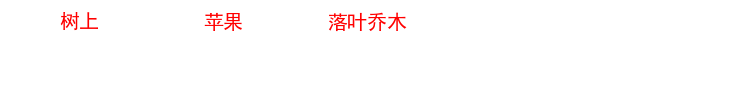

In [168]:
color_words(good_lda, text_fruit)

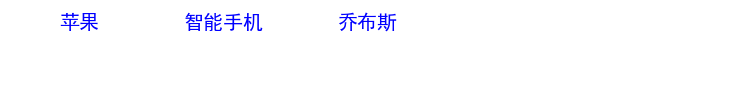

In [169]:
color_words(good_lda, text_comp)

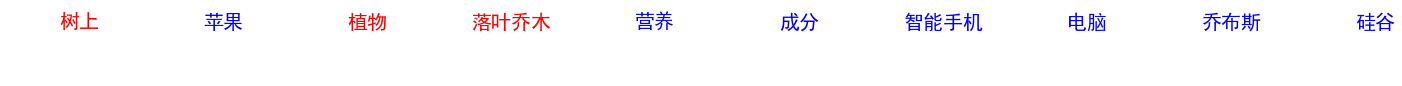

In [170]:
doc = ['苹果', '电脑', '苹果', '营养', '树上', '乔布斯', '智能手机', '硅谷', '植物', '落叶乔木', '成分']
color_words(good_lda, doc)

### 字典着色

In [161]:
def color_word_dict(model, dictionary):
    word_topics = []
    token2id = dictionary.token2id
    for word, index in token2id.items():
        probs = model.get_term_topics(word)
        try:
            if probs[0][1] >= probs[1][1]:
                word_topics.append((index, [0, 1]))
            else:
                word_topics.append((index, [1, 0]))
        except IndexError:
            word_topics.append((index, [probs[0][0]]))
    topic_colors = {0:'red', 1:'blue'}
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    word_pos = 1 / 10
    
    for index, probs in word_topics:
        ax.text(word_pos, .8, model.id2word[index],
               horizontalalignment='center', verticalalignment='center', 
               fontsize=20, color=topic_colors[probs[0]],
               transform=ax.transAxes)
        word_pos += .2
    ax.set_axis_off()
    plt.show()

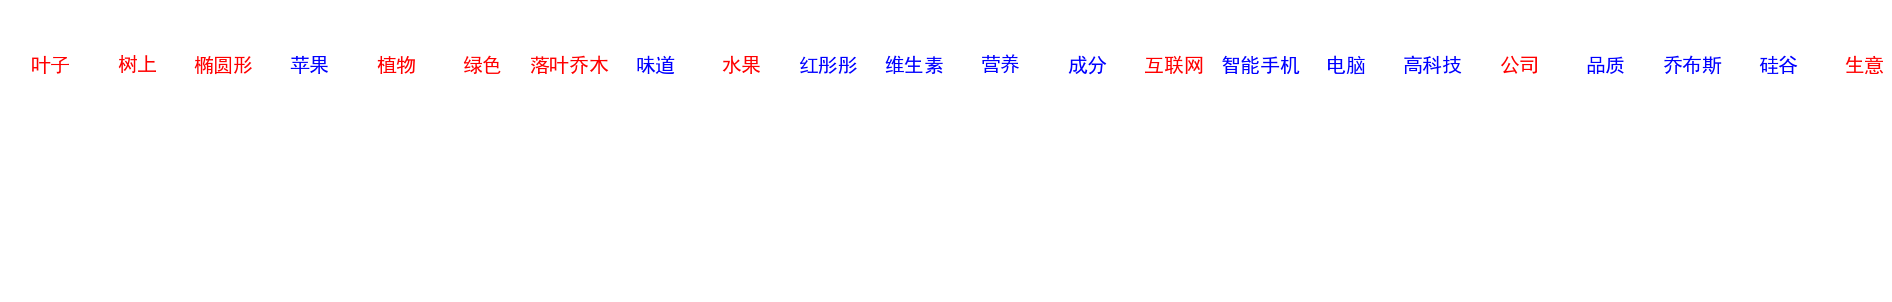

In [162]:
color_word_dict(good_lda, dictionary)

注意问题（从上面“红彤彤”，“互联网”，“公司”等词汇划分好主题）：
- lda需要大量的文本数据确保模型表现
- 适合长文本，不适合短文本
- 小语料库意味着算法对每个单词的划分可能不准确
- 增加语料库可提升模型表现

In [174]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1)],
 [(3, 1), (7, 1), (8, 1), (9, 1)],
 [(1, 1), (3, 1), (6, 1), (8, 1)],
 [(4, 1), (8, 1), (10, 1), (11, 1)],
 [(3, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1), (14, 1), (15, 1), (16, 1)],
 [(3, 1), (13, 1), (17, 1), (18, 1)],
 [(3, 1), (19, 1), (20, 1)],
 [(3, 1), (14, 1), (15, 1), (19, 1)],
 [(3, 1), (15, 1), (18, 1), (21, 1)],
 [(15, 1), (18, 1), (19, 1)],
 [(3, 1), (17, 1), (20, 1), (21, 1)]]

### 主题模型可视化

In [175]:
prepared = pyLDAvis.gensim.prepare(good_lda, corpus, dictionary)
pyLDAvis.show(prepared, open_browser = True)

2019-10-23 16:45:35,147: INFO: NumExpr defaulting to 8 threads.



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [23/Oct/2019 16:45:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2019 16:45:44] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2019 16:45:44] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2019 16:45:44] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2019 16:45:44] code 404, message Not Found
127.0.0.1 - - [23/Oct/2019 16:45:44] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


# word2vec训练使用与可视化

原始语料的两种处理思路：
- 原始语料 --> 清洗后存储 --> 迭代供模型使用
- 原始语料 --> 逐个迭代清洗 --> 供模型使用
    - 此处类采取的是第二种情况
- 是否迭代看内存情况与语料大小，空间和时间消耗选择自行权衡

In [203]:
# 词干提取
porter_stemmer = PorterStemmer()
print(porter_stemmer.stem('seeing'))
# 词形还原
wordnet_lemmatizer = WordNetLemmatizer()
print(wordnet_lemmatizer.lemmatize('sees'))

see
see


In [190]:
class MySentences:
    def __init__(self, path, stopwords):
        self.path = path
        self.stopwords = stopwords
    
    def __iter__(self):
        for fname in os.listdir(self.path):
            for line in smart_open(os.path.join(self.path, fname), 'r', encoding='utf-8'):
                line = line.lower()
                line = wordnet_lemmatizer.lemmatize(porter_stemmer.stem(line))
                line = line.replace('social listening', 'social_listening')
                yield [i.strip() for i in jieba.lcut(line) if i not in self.stopwords
                      and len(i) > 1]

In [191]:
sentences = MySentences('data/word2vec_corpus', stopwords)

In [204]:
model = models.Word2Vec(sentences, min_count=1)

2019-10-23 17:44:29,928: INFO: collecting all words and their counts
2019-10-23 17:44:29,935: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-23 17:44:29,972: INFO: collected 180 word types from a corpus of 280 raw words and 16 sentences
2019-10-23 17:44:29,973: INFO: Loading a fresh vocabulary
2019-10-23 17:44:29,975: INFO: effective_min_count=1 retains 180 unique words (100% of original 180, drops 0)
2019-10-23 17:44:29,975: INFO: effective_min_count=1 leaves 280 word corpus (100% of original 280, drops 0)
2019-10-23 17:44:29,978: INFO: deleting the raw counts dictionary of 180 items
2019-10-23 17:44:29,979: INFO: sample=0.001 downsamples 180 most-common words
2019-10-23 17:44:29,980: INFO: downsampling leaves estimated 162 word corpus (57.9% of prior 280)
2019-10-23 17:44:29,981: INFO: estimated required memory for 180 words and 100 dimensions: 234000 bytes
2019-10-23 17:44:29,982: INFO: resetting layer weights
2019-10-23 17:44:30,042: INFO: training 

In [207]:
# 语料太少，功能没太大意义
model.wv.most_similar('消费者')

[('opinions', 0.3493953347206116),
 ('收到', 0.2538139522075653),
 ('风向', 0.22122573852539062),
 ('发起', 0.21855100989341736),
 ('情报', 0.18707387149333954),
 ('过往', 0.18056842684745789),
 ('减弱', 0.16646486520767212),
 ('概率', 0.15951229631900787),
 ('价值', 0.15141227841377258),
 ('最低', 0.14463701844215393)]

In [208]:
print(model)

Word2Vec(vocab=180, size=100, alpha=0.025)


In [213]:
# 另一种构建可持续学习的模型，针对在线以及不可重复语料的场景
new_model = models.Word2Vec(min_count=1)
# 如果输入是文件流，需要LineSentence(file)进行转换后供给model
new_model.build_vocab(sentences)
new_model.train(sentences, total_examples=new_model.corpus_count, epochs=new_model.epochs)
print(new_model)

2019-10-23 18:04:22,993: INFO: collecting all words and their counts
2019-10-23 18:04:22,998: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-23 18:04:23,033: INFO: collected 180 word types from a corpus of 280 raw words and 16 sentences
2019-10-23 18:04:23,034: INFO: Loading a fresh vocabulary
2019-10-23 18:04:23,035: INFO: effective_min_count=1 retains 180 unique words (100% of original 180, drops 0)
2019-10-23 18:04:23,036: INFO: effective_min_count=1 leaves 280 word corpus (100% of original 280, drops 0)
2019-10-23 18:04:23,038: INFO: deleting the raw counts dictionary of 180 items
2019-10-23 18:04:23,039: INFO: sample=0.001 downsamples 180 most-common words
2019-10-23 18:04:23,040: INFO: downsampling leaves estimated 162 word corpus (57.9% of prior 280)
2019-10-23 18:04:23,042: INFO: estimated required memory for 180 words and 100 dimensions: 234000 bytes
2019-10-23 18:04:23,043: INFO: resetting layer weights
2019-10-23 18:04:23,101: INFO: training 

Word2Vec(vocab=180, size=100, alpha=0.025)


In [221]:
new_model2 = models.Word2Vec(min_count=1)
# 如果输入是文件流，需要LineSentence(file)进行转换后供给model；注意该方法必须提前处理好语料，否则就会如下
# Words must be already preprocessed and separated by whitespace.
sentences_ = models.word2vec.LineSentence('data/word2vec_corpus/corpus_word2vec.txt')
new_model2.build_vocab(sentences_)
new_model2.train(sentences_, total_examples=new_model.corpus_count, epochs=new_model.epochs)
print(new_model2),list(sentences_)

2019-10-23 18:09:17,062: INFO: collecting all words and their counts
2019-10-23 18:09:17,065: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-23 18:09:17,066: INFO: collected 41 word types from a corpus of 44 raw words and 16 sentences
2019-10-23 18:09:17,066: INFO: Loading a fresh vocabulary
2019-10-23 18:09:17,067: INFO: effective_min_count=1 retains 41 unique words (100% of original 41, drops 0)
2019-10-23 18:09:17,068: INFO: effective_min_count=1 leaves 44 word corpus (100% of original 44, drops 0)
2019-10-23 18:09:17,070: INFO: deleting the raw counts dictionary of 41 items
2019-10-23 18:09:17,070: INFO: sample=0.001 downsamples 41 most-common words
2019-10-23 18:09:17,071: INFO: downsampling leaves estimated 10 word corpus (24.2% of prior 44)
2019-10-23 18:09:17,073: INFO: estimated required memory for 41 words and 100 dimensions: 53300 bytes
2019-10-23 18:09:17,073: INFO: resetting layer weights
2019-10-23 18:09:17,087: INFO: training model with 3

Word2Vec(vocab=41, size=100, alpha=0.025)


(None,
 [['2018年10月份，麻省理工学院的Zakaria',
   'el',
   'Hjouji',
   'D.',
   'Scott',
   'Hunter等学者发表了《The',
   'Impact',
   'of',
   'Bots',
   'on',
   'Opinions',
   'in',
   'Social',
   'Networks》。'],
  ['该研究通过分析',
   'Twitter',
   '上的机器人在舆论事件中的表现，证实了社交网络机器人可以对社交网络舆论产生很大的影响，不到消费者总数1%的活跃机器人，就可能左右整个舆论风向。'],
  ['麻省理工学院研究组的这项工作，最大的发现是，影响社交网络舆论所需要的机器人，其实是很少的。少数活跃的机器人，可以对网络舆论产生重大影响。'],
  ['机器人检测算法，会判断某用户是机器人的概率，但实际操作中研究者发现，该算法把几个经常转发但不常被@',
   '的真实用户也当做了机器人。所以研究者对有实名认证的',
   'Twitter',
   '用户做了筛查，把他们都归为真实用户。'],
  ['不论是真实的推特用户还是推特机器人，它们的三个基本操作是，关注、转发和评论（类似微博）。通过跟踪这些互动，研究者可以有效量化',
   'Twitter',
   '账号的行为。'],
  ['直觉上，那些不太关注别人的用户，也不太可能关注你。而且社交圈子重叠很重要，如果',
   'A',
   '和',
   'B',
   '是好友，那么关注',
   'A',
   '的用户就有较大概率关注',
   'B。'],
  ['虽然人们在收到新信息时会更新他们的观点，但这个过程会随着时间的推移而减弱，他们的观点会逐渐变得顽固。Zaman',
   '认为，如果你已经掌握了很多信息，你就越来越难听从别人的观点，新说法不会改变你的看法。'],
  ['该研究团队基于过往研究，给出了网络舆论模型的核心假设：'],
  ['社交网络中的个人是基于其朋友推文中的观点，来更新自身的观点；'],
  ['网络中某些用户的观点是顽固的，其观点不会轻易改变，而且顽固用户会推动其他用户（摇摆不定的中间派）改变观点。'],
  ['虽然社交媒体机器人不会带来物理威胁，但它们

## 持久化与持续学习

需要持续学习的话，模型必须保存为全模型文件，不能只保存键值对文件
- 加载过往模型/生成空模型
- 进行新语料的增量学习

In [224]:
model.save(os.path.join(TEMP_FOLDER, 'word2vec.model'))

2019-10-23 18:18:03,713: INFO: saving Word2Vec object under D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model, separately None
2019-10-23 18:18:03,714: INFO: not storing attribute vectors_norm
2019-10-23 18:18:03,716: INFO: not storing attribute cum_table
2019-10-23 18:18:03,721: INFO: saved D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model


In [3]:
model = models.Word2Vec.load(os.path.join(TEMP_FOLDER, 'word2vec.model'))
print(model)

2019-10-23 18:46:53,999: INFO: loading Word2Vec object from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model
2019-10-23 18:46:54,004: INFO: loading wv recursively from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model.wv.* with mmap=None
2019-10-23 18:46:54,004: INFO: setting ignored attribute vectors_norm to None
2019-10-23 18:46:54,006: INFO: loading vocabulary recursively from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model.vocabulary.* with mmap=None
2019-10-23 18:46:54,006: INFO: loading trainables recursively from D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model.trainables.* with mmap=None
2019-10-23 18:46:54,007: INFO: setting ignored attribute cum_table to None
2019-10-23 18:46:54,008: INFO: loaded D:\Github\NLP\Artificial_Intelligence_for_NLP\Projects\2_autoSummarization\temp\word2vec.model


Word2Vec(vocab=180, size=100, alpha=0.025)


In [240]:
def clean_sentences(sentences_list:list, stopwords:list):
    sentences = [' '.join(jieba.cut(s)) for s in sentences_list]
    sentences = [[word for word in doc.lower().split() if word not in stopwords]
                for doc in sentences]
    return sentences

In [242]:
new_sentences = ['众所周知，社交聆听是一个需要社交媒体聆听/社交媒体监控工具的实现的过程（例如，Awario，Mention，Brandwatch）。',
'打开应用程序时，您要做的第一件事就是输入要监控的关键字。','关键字是最能描述您想要在社交媒体平台和网络上找到的内容的词。',
'关键字可以是一个单词（例如“飞利浦”），两个单词（例如“Aleh Barysevich”），四个单词（例如“搜索引擎优化工具”）等。',
'这些示例中的每一个都呈现一个关键字。输入关键字后，该工具会搜索这些关键字的提及次数并将其收集在一个位置。',
'监控营销（和其他）活动以及产品发布至关重要。',
'社交媒体上的反应非常迅速。只有通过实时监控此类事件，您才会立即知道它是否正常运行以及是否存在您在创建活动时可能没有注意到的问题。',
'你越早知道越好。要监控广告系列，请输入其名称（如果有），标语和/或主题标签作为关键字。']
new_clean_sentences = clean_sentences(new_sentences, stopwords)
model.build_vocab(new_clean_sentences, update=True)
model.train(new_clean_sentences, total_examples=model.corpus_count, epochs=model.epochs)
print(model)

2019-10-23 18:30:56,642: INFO: collecting all words and their counts
2019-10-23 18:30:56,643: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-23 18:30:56,644: INFO: collected 60 word types from a corpus of 85 raw words and 8 sentences
2019-10-23 18:30:56,644: INFO: Updating model with new vocabulary
2019-10-23 18:30:56,645: INFO: New added 60 unique words (50% of original 120) and increased the count of 60 pre-existing words (50% of original 120)
2019-10-23 18:30:56,647: INFO: deleting the raw counts dictionary of 60 items
2019-10-23 18:30:56,647: INFO: sample=0.001 downsamples 120 most-common words
2019-10-23 18:30:56,648: INFO: downsampling leaves estimated 49 word corpus (58.7% of prior 85)
2019-10-23 18:30:56,649: INFO: estimated required memory for 120 words and 100 dimensions: 156000 bytes
2019-10-23 18:30:56,650: INFO: updating layer weights
2019-10-23 18:30:56,668: INFO: training model with 3 workers on 232 vocabulary and 100 features, using sg=0

Word2Vec(vocab=232, size=100, alpha=0.025)


## 持续学习的优化策略之缓存

将查询字典缓存起来，加快查询速度

In [13]:
most_similars_precalc = {word: model.wv.most_similar(word) for word in model.wv.index2word}
for i, (key, value) in enumerate(most_similars_precalc.items()):
    if i == 5:
        break
    print(f"与【{key}】最相关的词汇是: \n {value}")

与【机器人】最相关的词汇是: 
 [('认证', 0.2719489336013794), ('识别', 0.2521708607673645), ('金子', 0.22522547841072083), ('数据挖掘', 0.22182640433311462), ('密度', 0.18195517361164093), ('zaman', 0.18047131597995758), ('僵尸', 0.17697754502296448), ('销售', 0.17411059141159058), ('角度', 0.16212712228298187), ('看似', 0.15850377082824707)]
与【用户】最相关的词汇是: 
 [('不太', 0.2577117085456848), ('搜索', 0.24347910284996033), ('社会化', 0.24073421955108643), ('浏览者', 0.21051475405693054), ('操控', 0.1978422999382019), ('社交圈子', 0.18944187462329865), ('hjouji', 0.1885153204202652), ('营销', 0.16477084159851074), ('文章', 0.15027263760566711), ('认证', 0.1484912931919098)]
与【舆论】最相关的词汇是: 
 [('社交圈子', 0.24106180667877197), ('bots', 0.23350849747657776), ('公关', 0.2256145477294922), ('客观', 0.20652201771736145), ('物理', 0.20188850164413452), ('数据', 0.19837093353271484), ('沙子', 0.1766655147075653), ('带来', 0.17397211492061615), ('三个', 0.17237557470798492), ('蕴含着', 0.16069327294826508)]
与【网络】最相关的词汇是: 
 [('不论是', 0.23934946954250336), ('表现', 0.234810650348

In [16]:
%%time
# 无缓存
words = ['商业', '数据', '文本', '媒体']
for word in words:
    result = model.wv.most_similar(word)
    print(f"与【{word}】最相关的词汇是：\n {result}")

与【商业】最相关的词汇是：
 [('决策', 0.276513934135437), ('判断', 0.2578871250152588), ('影响力', 0.2541733682155609), ('算法', 0.22188061475753784), ('足够', 0.2191009223461151), ('用以', 0.2088950276374817), ('受众', 0.19619113206863403), ('物理', 0.1886662095785141), ('社交', 0.18834272027015686), ('twitter', 0.17598950862884521)]
与【数据】最相关的词汇是：
 [('社交圈子', 0.36156123876571655), ('好比', 0.3348948359489441), ('当做', 0.23842166364192963), ('各类', 0.2250472903251648), ('舆论', 0.19837093353271484), ('不太可能', 0.19258415699005127), ('足够', 0.19135279953479767), ('蕴含着', 0.18743714690208435), ('直觉', 0.18527060747146606), ('关注', 0.17979882657527924)]
与【文本】最相关的词汇是：
 [('物理', 0.326978474855423), ('好友', 0.30594292283058167), ('月份', 0.19317810237407684), ('角度', 0.1789444535970688), ('研究组', 0.1777227520942688), ('社交', 0.16687233746051788), ('发现', 0.15642115473747253), ('情绪', 0.14816918969154358), ('公关', 0.12980999052524567), ('量化', 0.12490525841712952)]
与【媒体】最相关的词汇是：
 [('社交', 0.24651837348937988), ('真实性', 0.24446488916873932), ('评论', 0

In [17]:
%%time
# 有缓存
for word in words:
    try:
        result = most_similars_precalc[word]
    except KeyError:
        pass
    print(f"与【{word}】最相关的词汇是：\n {result}")

与【商业】最相关的词汇是：
 [('决策', 0.276513934135437), ('判断', 0.2578871250152588), ('影响力', 0.2541733682155609), ('算法', 0.22188061475753784), ('足够', 0.2191009223461151), ('用以', 0.2088950276374817), ('受众', 0.19619113206863403), ('物理', 0.1886662095785141), ('社交', 0.18834272027015686), ('twitter', 0.17598950862884521)]
与【数据】最相关的词汇是：
 [('社交圈子', 0.36156123876571655), ('好比', 0.3348948359489441), ('当做', 0.23842166364192963), ('各类', 0.2250472903251648), ('舆论', 0.19837093353271484), ('不太可能', 0.19258415699005127), ('足够', 0.19135279953479767), ('蕴含着', 0.18743714690208435), ('直觉', 0.18527060747146606), ('关注', 0.17979882657527924)]
与【文本】最相关的词汇是：
 [('物理', 0.326978474855423), ('好友', 0.30594292283058167), ('月份', 0.19317810237407684), ('角度', 0.1789444535970688), ('研究组', 0.1777227520942688), ('社交', 0.16687233746051788), ('发现', 0.15642115473747253), ('情绪', 0.14816918969154358), ('公关', 0.12980999052524567), ('量化', 0.12490525841712952)]
与【媒体】最相关的词汇是：
 [('社交', 0.24651837348937988), ('真实性', 0.24446488916873932), ('评论', 0

## 常用API

In [223]:
model.wv.vectors.shape

(180, 100)

In [245]:
# postive, negative同时使用，即词汇类比，word analogy
model.wv.most_similar(positive=['社交', '平台'], negative=['内容'],topn=20)

[('el', 0.2753462791442871),
 ('提炼', 0.260596364736557),
 ('信息', 0.2136840522289276),
 ('潜在', 0.2105185091495514),
 ('核心', 0.2078903317451477),
 ('公关', 0.2008153796195984),
 ('最终', 0.1980503499507904),
 ('媒体', 0.19680368900299072),
 ('输入', 0.19662503898143768),
 ('情绪', 0.19497150182724),
 ('危机', 0.19382579624652863),
 ('表现', 0.19245176017284393),
 ('几个', 0.17243903875350952),
 ('相比', 0.1710217148065567),
 ('研究', 0.1686897724866867),
 ('研究者', 0.1665807068347931),
 ('各类', 0.16344007849693298),
 ('真实', 0.16105933487415314),
 ('产品', 0.1601671576499939),
 ('筛查', 0.15833434462547302)]

In [248]:
# 与其他词汇差异最大的词汇
model.wv.doesnt_match(['危机', '产品', '平台'])

'危机'

In [249]:
# 基于余弦相似度计算词汇差异，越大相似度越高
model.wv.similarity('公关', '研究')

-0.038906284

In [5]:
# 基于余弦距离计算的文本相似度匹配函数，数值越大越不相似
doc1 = '基于 微博 数据 的 用户画像 分析 ， 重点 在于 从 数据 中 挖掘 出 用户 偏好'
doc2 = '语义 分析 也 是 social_listening  中 的 一个 重要 技术 手段'
model.wv.wmdistance(doc1.split(), doc2.split())

ModuleNotFoundError: No module named 'pyemd'

In [4]:
# 给定上下文，获得中心词汇的概率分布
model.predict_output_word(['social_listening', '口碑', '情报'])

[('排沙简金', 0.005555612),
 ('淘沙得金', 0.0055555934),
 ('客观', 0.0055555874),
 ('不太', 0.005555584),
 ('推特', 0.005555583),
 ('机器人', 0.0055555813),
 ('最低', 0.005555581),
 ('世界', 0.0055555785),
 ('时会', 0.0055555776),
 ('服务', 0.0055555766)]

# 文本聚类

## DBSCAN

In [19]:
op = OptionParser()
op.add_option('--lsa', dest='n_components', type='int', 
              default=120, help='利用潜在语义分析对文本数据进行处理')
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=False,
              help="使用一般的K-means算法 (使用batch模式).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=False,
              help="禁用逆向文档频率特征加权。")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="使用Hashing特征向量")
op.add_option("--n-features", type=int, default=40000,
              help="从文本中提取的最大特征（维度）数量。")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="在K-means算法中打印进度报告。")
print(__doc__)
op.print_help()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    利用潜在语义分析对文本数据进行处理
  --no-minibatch        使用一般的K-means算法 (使用batch模式).
  --no-idf              禁用逆向文档频率特征加权。
  --use-hashing         使用Hashing特征向量
  --n-features=N_FEATURES
                        从文本中提取的最大特征（维度）数量。
  --verbose             在K-means算法中打印进度报告。


In [28]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

argv = [] if is_interactive() else sys.argv[1:]
opts, args = op.parse_args(argv)
if len(args) > 0:
    op.error('该脚本不需要设置参数')
    sys.exit(1)

In [44]:
df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [45]:
df_sample = df.sample(10000)
df_sample.tail(3)

,content,title,summary
84045,新华社 北京 ６ 月 ５ 日电 题 ： 把握 正确 路径 与 节奏 助力 深化 国际 合作...,（经济）把握正确路径与节奏 助力深化国际合作——海外专家评中国新一轮高水平对外开放,新华社北京６月５日电题：把握正确路径与节奏 助力深化国际合作——海外专家评中国新一轮高水...
12411,新华社 照片 ， 乌鲁木齐 ， 2017 年 3 月 31 日 （ 体育 ） （ 8 ） 篮...,（体育）（8）篮球——CBA总决赛首场：新疆战胜广东,新华社照片，乌鲁木齐，2017年3月31日 （体育）（8）篮球——CBA总决赛首场：新疆战胜...
60031,新华社 照片 ， 伦敦 ， 2017 年 5 月 16 日 （ 体育 ） （ 12 ） 足球...,（体育）（12）足球——英超：切尔西胜沃特福德,新华社照片，伦敦，2017年5月16日 （体育）（12）足球——英超：切尔西胜沃特福德 5月...


In [35]:
df_sample.isna().sum()

content      0
title        0
summary    651
dtype: int64

In [46]:
vectorizer = TfidfVectorizer(max_df=.5, max_features=10000, min_df=5, stop_words=stopwords,
                            ngram_range=(1,2), use_idf=True)

In [47]:
%%time
X = vectorizer.fit_transform(df_sample.content)
print(X.shape)

(10000, 10000)
Wall time: 6.82 s


In [48]:
svd = TruncatedSVD(20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [49]:
%time X = lsa.fit_transform(X)

Wall time: 403 ms


In [50]:
explained_variance = svd.explained_variance_ratio_.sum()
explained_variance

0.10440098973434962

In [51]:
db = DBSCAN(eps=.2, min_samples=4).fit(X)

In [58]:
core_sampels_mask = np.zeros_like(db.labels_, dtype=bool)
core_sampels_mask[db.core_sample_indices_] = True
db.core_sample_indices_

array([   0,    2,    3, ..., 9995, 9998, 9999], dtype=int64)

In [63]:
cluster_index = db.labels_

In [64]:
np.unique(cluster_index)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164], dtype=int64)

In [65]:
df_sample['cluster'] = cluster_index
df_sample.head()

,content,title,summary,cluster
66989,新华社 照片 ， 外代 ， 2017 年 5 月 22 日 （ 外代 二线 ） 彩虹 跑 5...,[1]（外代二线）彩虹跑,新华社照片，外代，2017年5月22日 （外代二线）彩虹跑 5月20日，在捷克首都布拉格，参...,0
77941,新华社 照片 ， 内罗毕 ， 2017 年 5 月 31 日 （ 国际 · 图文 互动 ） ...,（国际·图文互动）（6）摆脱“人弹”厄运——索马里前娃娃兵重返社会之路,新华社照片，内罗毕，2017年5月31日 （国际·图文互动）（6）摆脱“人弹”厄运——索马里...,-1
59023,新华社 照片 ， 蒂尔 堡 ， 2017 年 5 月 15 日 （ 体育 ） （ 2 ） 足...,（体育）（2）足球——荷甲：阿贾克斯胜威廉二世,新华社照片，蒂尔堡，2017年5月15日 （体育）（2）足球——荷甲：阿贾克斯胜威廉二世 5...,1
72627,新华社 照片 ， 外代 ， 2017 年 5 月 26 日 （ 外代 二线 ） 影片 《 神...,[21]（外代二线）影片《神奇女侠》世界首映式,新华社照片，外代，2017年5月26日 （外代二线）影片《神奇女侠》世界首映式 5月25日，...,0
12071,新华社 台北 3 月 31 日电 （ 记者 刘欢 吴济海 ） 台湾 交通 主管部门 3 月 ...,（港澳台）台湾“2·13”游览车事故33名罹难者已完成理赔 2名官员遭记大过处分,新华社台北3月31日电（记者刘欢 吴济海）台湾交通主管部门3月31日召开记者会，公布“2·1...,2


In [82]:
df_sample[df_sample.cluster == 14].title

84310           （体育）（4）乒乓球——世乒赛男单决赛：马龙对阵樊振东
82094               （体育）（6）乒乓球——世乒赛：朱雨玲晋级决赛
82189         （体育）（8）乒乓球——世乒赛：吉村真晴/石川佳纯混双夺冠
79836                 （体育）（4）乒乓球——世乒赛：林高远晋级
82001               （体育）（10）乒乓球——世乒赛：丁宁晋级决赛
84118               （体育）（5）乒乓球——世乒赛：樊振东晋级决赛
78469                （体育）（2）乒乓球——世乒赛：林高远胜哈宁
77622                    （体育）乒乓球——世乒赛：王励勤观赛
84490            （体育）（1）乒乓球——世乒赛：丁宁/刘诗雯女双夺冠
78463                （体育）（3）乒乓球——世乒赛：张继科胜纳吉
84534                （体育）（2）乒乓球——世乒赛：女双颁奖仪式
84130               （体育）（6）乒乓球——世乒赛：李尚洙无缘决赛
81871            （体育）（2）乒乓球——世乒赛：方博/索尔佳无缘决赛
84447    （体育）（2）乒乓球——世乒赛女双决赛：丁宁/刘诗雯对阵陈梦/朱雨玲
81196             （体育）（8）乒乓球——世乒赛：平野美宇晋级半决赛
77627         （体育）（4）乒乓球——世乒赛：方博／索尔加晋级混双16强
67955                （体育）（2）乒乓球——国乒卢森堡备战世乒赛
83133             （体育）（16）乒乓球——世乒赛女单决赛：丁宁夺冠
79619          （体育）（4）乒乓球——世乒赛：樊振东/许昕晋级男双八强
79837                 （体育）（3）乒乓球——世乒赛：林高远晋级
84185          （体育）（2）乒乓球——世乒赛：陈梦/朱雨玲晋级女双决赛
79675                  （体育）（4）乒乓球——世乒赛：丁宁晋级
80833               （体育）（2）乒乓球——

In [94]:
n_clusters = len(np.argwhere(np.unique(cluster_index) != -1))
n_noise = len(np.argwhere(cluster_index == -1))
n_clusters, n_noise

(165, 3172)

Text(0.5, 1.0, '大致聚类数：165')

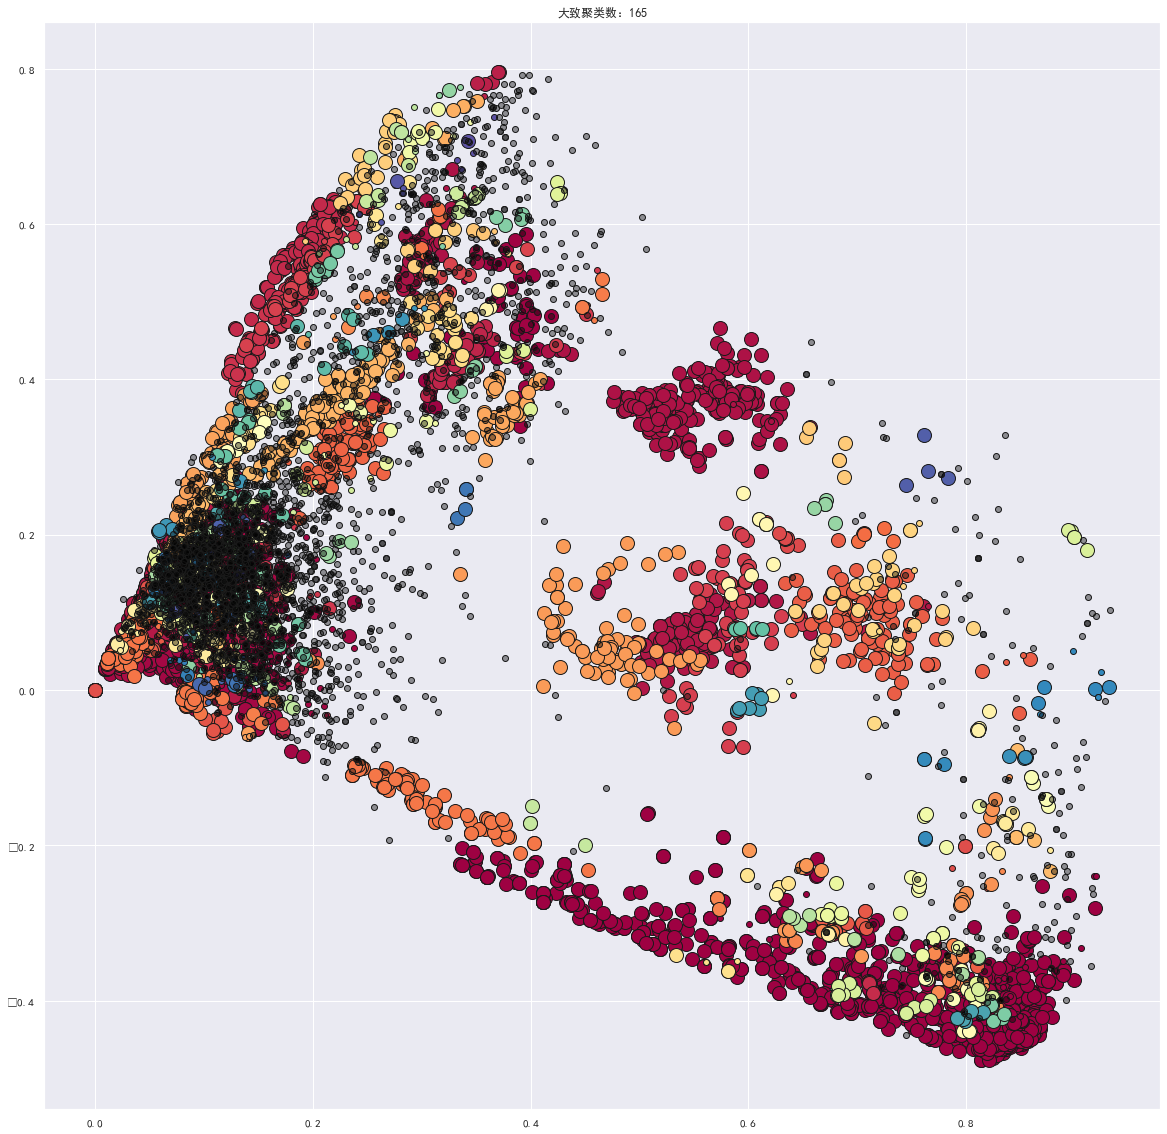

In [104]:
unique_labels = set(cluster_index)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(20,20))
for k, col in zip(unique_labels, colors):
    if k < 0:
        col = [0, 0, 0, .4]
    
    class_member_mask = (cluster_index == k)
    
    xy = X[class_member_mask & core_sampels_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=14)
    
    xy = X[class_member_mask & ~core_sampels_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=6)
plt.title(f"大致聚类数：{n_clusters}")


## Single-pass 持续化聚类
步骤
- 以第一篇文章为种子，建立主题
- 基于词袋模型将新文档向量化
- 将新文档与所有话题做相似度比较，相似度方式任选
- 找到与该文档最大相似度的已有主题
- 若相似度大于阈值，则把该文档加入该主题
- 若小于阈值，则新文档不属于已有的任何主题，针对该文档创建新主题类别
- 聚类结束，等待新文档加入

In [3]:
def flatten_list(list_):
    for s in list_:
        if isinstance(s, list):
            yield from flatten_list(s)
        else:
            yield s

In [4]:
def split_sentence(doc):
    ss = SentenceSplitter()
    # 去除换行符产生的''
    return [sentence for sentence in ss.split(doc.strip().strip('\ufeff')) if sentence]

In [109]:
# 该api返回的是余弦相似度，[-1,1]
# 和直接传入的一般向量格式不同，这里传入元组列表，每个元组的0元素为序列号，1元素为权重，所有1元素构成向量
matutils.cossim([(0, 1),(1,0)],[(0,-1),(1,0)])

-1.0

In [11]:
class SinglePassCluster:
    def __init__(self, theta=.85):
        self.theta=theta
        
    def load_data(self, filename):
        with smart_open(filename, 'r', encoding='utf-8') as f:
            texts = [split_sentence(s) for s in f]
            print(f"未切分钱的语句总数为：{len(texts)} 条")
            print('-'*30)
            texts = [i.strip() for i in list(flatten_list(texts)) if len(i)>5]
            print(f"切分后语句总数为：{len(texts)} 条")
        return texts
    
    def segment_word(self, docs, stopwords):
        segmentation = [[word for word in jieba.cut(doc) if word not in stopwords
               if word != ' '] for doc in docs]
        return segmentation
    
    def get_dictionary(self, segmentation):
        return corpora.Dictionary(segmentation)
    
    def get_tfidf_vec(self, dictionary, segmentation, pivot=10, slope=.1):
        doc2bow = [dictionary.doc2bow(seg) for seg in segmentation]
        tfidf = models.TfidfModel(doc2bow, pivot=pivot, slope=slope)
        doc2tfidf = tfidf[doc2bow]
        return doc2tfidf
    
    def get_max_similarity(self, topic_dict, vector):
        max_index = -1
        max_value = 0
        for k, vec in topic_dict.items():
            new_similarity = np.mean([matutils.cossim(vector, v) for v in vec])
            if new_similarity > max_value:
                max_value = new_similarity
                max_index = k
        return max_index, max_value
        
    def single_pass(self, doc2vec, texts, theta):
        topic_dict = {}  # 键，索引；值，向量
        topic_cluster = {}  # 键，索引；值，文本
        topic_num = 0
        count = 0
        for vec, text in zip(doc2vec, texts):
            if not topic_num:
                topic_dict[topic_num] = []
                topic_dict[topic_num].append(vec)
                topic_cluster[topic_num] = []
                topic_cluster[topic_num].append(text)
                topic_num += 1
            else:
                max_index, max_value = self.get_max_similarity(topic_dict, vec)
                if max_value > theta:
                    topic_dict[max_index].append(vec)
                    topic_cluster[max_index].append(text)
                else:
                    topic_dict[topic_num] = []
                    topic_dict[topic_num].append(vec)
                    topic_cluster[topic_num] = []
                    topic_cluster[topic_num].append(text)
                    topic_num += 1
            count += 1
            if count % 1000 == 0:
                print(f"Processing {cnt}...")
        return topic_dict, topic_cluster
    
    def fit_transform(self, filename, stopwords, theta=.5):
        texts = self.load_data(filename)
        segmentation = self.segment_word(texts, stopwords)
        dictionary = self.get_dictionary(segmentation)
        doc2tfidf = self.get_tfidf_vec(dictionary, segmentation)
        topic_dict, topic_cluster = self.single_pass(doc2tfidf, texts, theta)
        
        print(f"得到的主题数为：{len(topic_dict)}")
        print('\n' + '--' * 20)
        # 按照聚类包含的主题数量排序
        topic_cluster_sorted = sorted(topic_cluster.items(), key=lambda x: len(x[1]), reverse=True)
        for k in topic_cluster_sorted:
            cluster_title = '\n'.join(k[1])
            # 获取每个聚类中主题的关键词
            key_word = TextRank4Keyword()
            key_word.analyze(''.join(flatten_list(self.segment_word(''.join(cluster_title), stopwords))), window=5,
                            lower=True)
            key_word_list = key_word.get_keywords(num=10, word_min_len=2)
            
            # 获取每个聚类中关键句top3
            sentence = TextRank4Sentence()
            sentence.analyze(' '.join(k[1]), lower=True)
            sentence_list = sentence.get_key_sentences(num=3, sentence_min_len=3)
            print(f" 【主题索引】:{k[0]} \n 【主题长度】: {len(k[1])} \n 【主题关键词】：{key_word_list} \n 【主题关键句】：\n{sentence_list}")
            print('-' * 50)

In [12]:
spc = SinglePassCluster()
spc.fit_transform('data/corpus_pm.txt', stopwords, theta=.1)

未切分钱的语句总数为：26 条
------------------------------
切分后语句总数为：40 条


2019-10-24 16:54:06,811: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2019-10-24 16:54:06,814: INFO: built Dictionary(311 unique tokens: ['万首', '全唐诗', '剖析', '实操', '挖掘']...) from 40 documents (total 476 corpus positions)
2019-10-24 16:54:06,815: INFO: collecting document frequencies
2019-10-24 16:54:06,816: INFO: PROGRESS: processing document #0
2019-10-24 16:54:06,816: INFO: calculating IDF weights for 40 documents and 311 features (459 matrix non-zeros)


得到的主题数为：22

----------------------------------------
 【主题索引】:1 
 【主题长度】: 4 
 【主题关键词】：[{'word': '舆情', 'weight': 0.08140057369462857}, {'word': '挖掘', 'weight': 0.06551945437931532}, {'word': '文章', 'weight': 0.057843991977364666}, {'word': '中文', 'weight': 0.05623105992255033}, {'word': '远值', 'weight': 0.05623105992255033}, {'word': '崛例', 'weight': 0.045327381681572285}, {'word': '展现', 'weight': 0.044793657419039186}, {'word': '运营', 'weight': 0.03900703531554489}, {'word': '型析重', 'weight': 0.03900703531554489}, {'word': '帝国', 'weight': 0.03807181569722666}] 
 【主题关键句】：
[{'index': 1, 'sentence': '以《大秦帝国之崛起》为例，来谈大数据舆情分析和文本挖掘', 'weight': 0.28956336841403124}, {'index': 3, 'sentence': '数据运营|数据分析中，文本分析远比数值型分析重要', 'weight': 0.24714048879091144}, {'index': 0, 'sentence': '以虎嗅网4W+文章的文本挖掘为例，展现数据分析的一整套流程', 'weight': 0.23895977204658955}]
--------------------------------------------------
 【主题索引】:3 
 【主题长度】: 4 
 【主题关键词】：[{'word': '语料', 'weight': 0.08461385820753771}, {'word': '模型', 'weight': 0.0755687

# 文本特征提取方法总结

逐个读取的几个方法

1.函数

In [49]:
def load_data(filename):
    for line in smart_open(filename, encoding='utf-8'):
            yield line

Wall time: 0 ns


In [50]:
data = load_data('data/corpus.txt')

In [78]:
next(data)

' 6 月 21 日 ， A股 纳入 MSCI 指数 尘埃落定 ， 但 当天 被 寄予厚望 的 券商 股 并未 扛起 反弹 大旗 。 22 日 ， 在 222 只 纳入 MSCI 指数 的 A股 股票 中 ， 银行 股 全线 飘红 ， 其中 招商银行 领涨 ， 涨幅 达 6.66% 。 保险 股 和 券商 股 的 表现 也 可圈可点 。 在 这 222 只 股票 中 ， 金融 板块 的 股票 数量 和 总 市值 占 比均 位居 首位 。 分析 人士 指出 ， 银行 股 股息 率高 、 估值 低 、 收益 稳定 ， 对于 资金量 较大 、 投资 期限 较长 的 资金 存在 相当 大 的 吸引力 。 从 国际 经验 来看 ， 纳入 MSCI 指数 后 ， 相关 股市 的 投资者 风格 将 更加 稳健 ， 更加 偏好 业绩 稳定 、 流动性 好 、 风险 低 的 优质 蓝筹股 。 银行 股具 估值 优势 6 月 22 日 ， A股 金融股 表现 强势 ， 板块 涨幅 达 1.19% 。 据 平安 证券 统计 ， 在 222 只 纳入 MSCI 指数 的 A股 股票 中 ， 金融 板块 市值 占 比达 41.32% ， 其中 银行 、 证券 和 保险 子 板块 的 市值 占 比 分别 为 27.30% 、 7.75% 和 6.24% 。 多家 券商 研究 报告 认为 ， 银行 等 金融股 受到 纳入 MSCI 指数 的 提振 ， 未来 更 多 境外 资金 将 进入 金融股 。 华泰 证券 表示 ， 在 纳入 MSCI 指数 之后 ， A股 将 迎来 约 850 亿元 人民币 的 增量 资金 。 其中 ， 考虑 到 222 只 股票 中 ， 金融股 市值 占 比约 42% ， 并且 金融股 体量 大 、 流动性 强 、 估值 低 ， 符合 境外 资金 偏好 ， 有望 迎来 超过 权重 的 资金 比例 。 预计 金融股 有望 吸引 增量 资金 约 350 亿元 人民币 。 新富 资本 证券 投资 中心 研究 总监 廖 云龙 认为 ， 银行 股 脱颖而出 的 主要 原因 是 低 估值 。 市场 预期 银行 股 基本面 改善 ， 同时 市场 整体 风格 偏 保守 ， 偏爱 低 估值 。 22 日 银行 股 的 大涨 是 市场 风格 的 延续 ， 是 投资者 对 龙头股 和 对 低 

2. 类

In [52]:
class Corpus:
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for line in smart_open(self.filename, encoding='utf-8'):
            yield line

In [79]:
t = Corpus('data/corpus.txt')
t = iter(t)

In [89]:
next(t)

' 6 月 21 日 ， A股 纳入 MSCI 指数 尘埃落定 ， 但 当天 被 寄予厚望 的 券商 股 并未 扛起 反弹 大旗 。 22 日 ， 在 222 只 纳入 MSCI 指数 的 A股 股票 中 ， 银行 股 全线 飘红 ， 其中 招商银行 领涨 ， 涨幅 达 6.66% 。 保险 股 和 券商 股 的 表现 也 可圈可点 。 在 这 222 只 股票 中 ， 金融 板块 的 股票 数量 和 总 市值 占 比均 位居 首位 。 分析 人士 指出 ， 银行 股 股息 率高 、 估值 低 、 收益 稳定 ， 对于 资金量 较大 、 投资 期限 较长 的 资金 存在 相当 大 的 吸引力 。 从 国际 经验 来看 ， 纳入 MSCI 指数 后 ， 相关 股市 的 投资者 风格 将 更加 稳健 ， 更加 偏好 业绩 稳定 、 流动性 好 、 风险 低 的 优质 蓝筹股 。 银行 股具 估值 优势 6 月 22 日 ， A股 金融股 表现 强势 ， 板块 涨幅 达 1.19% 。 据 平安 证券 统计 ， 在 222 只 纳入 MSCI 指数 的 A股 股票 中 ， 金融 板块 市值 占 比达 41.32% ， 其中 银行 、 证券 和 保险 子 板块 的 市值 占 比 分别 为 27.30% 、 7.75% 和 6.24% 。 多家 券商 研究 报告 认为 ， 银行 等 金融股 受到 纳入 MSCI 指数 的 提振 ， 未来 更 多 境外 资金 将 进入 金融股 。 华泰 证券 表示 ， 在 纳入 MSCI 指数 之后 ， A股 将 迎来 约 850 亿元 人民币 的 增量 资金 。 其中 ， 考虑 到 222 只 股票 中 ， 金融股 市值 占 比约 42% ， 并且 金融股 体量 大 、 流动性 强 、 估值 低 ， 符合 境外 资金 偏好 ， 有望 迎来 超过 权重 的 资金 比例 。 预计 金融股 有望 吸引 增量 资金 约 350 亿元 人民币 。 新富 资本 证券 投资 中心 研究 总监 廖 云龙 认为 ， 银行 股 脱颖而出 的 主要 原因 是 低 估值 。 市场 预期 银行 股 基本面 改善 ， 同时 市场 整体 风格 偏 保守 ， 偏爱 低 估值 。 22 日 银行 股 的 大涨 是 市场 风格 的 延续 ， 是 投资者 对 龙头股 和 对 低 

3. pandas

In [3]:
df_reader = pd.read_csv('data/cleaned_data.csv', index_col=0, iterator=True)

In [4]:
# 读取后内容停在上一次读取的位置，下一次读取将从上一次的位置往后
df = df_reader.get_chunk(1000)

In [5]:
df.tail(3)

,content,title,summary
997,纽约商品交易所 黄金 期货市场 交投 最 活跃 的 ８ 月 黄金 期价 ２ ０ 日比前 一...,纽约金价２０日下跌,NaN
998,23 日 上午 有 网友 分享 了 这个 惊人 的 画面 ， 影片 中 机车行 老板 原本 ...,轿车失控冲向路边机车老板神后翻救女童,NaN
999,我们 现在 拥有 强大 而 稳定 的 领导力 ， 不过 是 在 法国 ， 而 非 英国 。...,法国不会帮助英国“软退欧”,NaN


## `CounterVctorizer`

In [125]:
ctv = CountVectorizer(stop_words=stopwords)

In [129]:
# 输入须为空格分开的句子
doc2ctv = ctv.fit_transform(df.content)

In [137]:
print(doc2ctv[0])

  (0, 25167)	1
  (0, 17497)	1
  (0, 20992)	1
  (0, 25300)	2
  (0, 24571)	1
  (0, 24680)	1
  (0, 12025)	2
  (0, 19027)	1
  (0, 7278)	1
  (0, 8977)	1
  (0, 32003)	1
  (0, 24568)	1
  (0, 19573)	1
  (0, 31441)	1
  (0, 18038)	1
  (0, 32737)	2
  (0, 32812)	1
  (0, 17991)	1
  (0, 24863)	1
  (0, 29522)	1
  (0, 30112)	1
  (0, 2006)	3
  (0, 31362)	1
  (0, 5272)	1
  (0, 11780)	1
  (0, 37921)	1
  (0, 2930)	1
  (0, 24868)	1
  (0, 24681)	1
  (0, 31444)	1
  (0, 7711)	1
  (0, 32484)	1
  (0, 16746)	1


In [136]:
doc2ctv[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [138]:
vocab = ctv.get_feature_names()
len(vocab)

42990

In [145]:
digits = [s for s in vocab if s.isdigit()]
len(digits)

905

## `Tfidf`

In [160]:
doc2tfv = TfidfVectorizer(stop_words=stopwords).fit_transform(df.content)

In [161]:
print(doc2tfv[0])

  (0, 16746)	0.15737151766160717
  (0, 32484)	0.11179005268592208
  (0, 7711)	0.07992403586293992
  (0, 31444)	0.16294616012979984
  (0, 24681)	0.18026258127081007
  (0, 24868)	0.18026258127081007
  (0, 2930)	0.08407698144999963
  (0, 37921)	0.18026258127081007
  (0, 11780)	0.07636405442474863
  (0, 5272)	0.11260921836540064
  (0, 31362)	0.11179005268592208
  (0, 2006)	0.5407877438124302
  (0, 30112)	0.16294616012979984
  (0, 29522)	0.13550028197460356
  (0, 24863)	0.09329314509535477
  (0, 17991)	0.06559234314751033
  (0, 32812)	0.18026258127081007
  (0, 32737)	0.27100056394920713
  (0, 18038)	0.1299256395064109
  (0, 31441)	0.10193067738227476
  (0, 19573)	0.07342156153738676
  (0, 24568)	0.18026258127081007
  (0, 32003)	0.18026258127081007
  (0, 8977)	0.17013312425662405
  (0, 7278)	0.18026258127081007
  (0, 19027)	0.09657422245735045
  (0, 12025)	0.14220731810956544
  (0, 24680)	0.11524136794623144
  (0, 24571)	0.12151978413398658
  (0, 25300)	0.28011019304119383
  (0, 20992)	0.090

In [162]:
# 或者采取这样的方式，用ContVectorizer的输出作为TfidfTransformer的输入，结果是一样的
doc2tft = TfidfTransformer().fit_transform(doc2ctv)
print(doc2tft[0])

  (0, 37921)	0.18026258127081005
  (0, 32812)	0.18026258127081005
  (0, 32737)	0.2710005639492071
  (0, 32484)	0.11179005268592207
  (0, 32003)	0.18026258127081005
  (0, 31444)	0.16294616012979982
  (0, 31441)	0.10193067738227475
  (0, 31362)	0.11179005268592207
  (0, 30112)	0.16294616012979982
  (0, 29522)	0.13550028197460354
  (0, 25300)	0.2801101930411938
  (0, 25167)	0.1253708249604175
  (0, 24868)	0.18026258127081005
  (0, 24863)	0.09329314509535476
  (0, 24681)	0.18026258127081005
  (0, 24680)	0.11524136794623142
  (0, 24571)	0.12151978413398656
  (0, 24568)	0.18026258127081005
  (0, 20992)	0.09005349287712595
  (0, 19573)	0.07342156153738674
  (0, 19027)	0.09657422245735044
  (0, 18038)	0.12992563950641087
  (0, 17991)	0.06559234314751032
  (0, 17497)	0.1376740275949701
  (0, 16746)	0.15737151766160712
  (0, 12025)	0.1422073181095654
  (0, 11780)	0.07636405442474861
  (0, 8977)	0.17013312425662402
  (0, 7711)	0.0799240358629399
  (0, 7278)	0.18026258127081005
  (0, 5272)	0.11260

## `HashingVectorizer` 

In [163]:
doc2hv = HashingVectorizer().transform(df.content)
print(doc2hv[0])

  (0, 772)	-0.125
  (0, 32866)	-0.125
  (0, 59200)	0.125
  (0, 59607)	0.125
  (0, 86220)	-0.125
  (0, 105664)	-0.125
  (0, 146008)	-0.125
  (0, 169928)	0.125
  (0, 171914)	-0.125
  (0, 182434)	-0.125
  (0, 200474)	-0.125
  (0, 210299)	0.125
  (0, 239078)	-0.125
  (0, 268249)	-0.125
  (0, 285737)	0.125
  (0, 293813)	0.125
  (0, 369401)	0.125
  (0, 371819)	-0.125
  (0, 392563)	-0.125
  (0, 409601)	0.125
  (0, 507712)	0.125
  (0, 526078)	0.25
  (0, 561105)	-0.125
  (0, 611317)	-0.125
  (0, 615885)	0.125
  (0, 631061)	0.25
  (0, 654286)	-0.125
  (0, 664113)	-0.125
  (0, 665059)	-0.125
  (0, 672647)	0.125
  (0, 689118)	0.125
  (0, 733971)	0.125
  (0, 746417)	-0.125
  (0, 774984)	0.125
  (0, 779779)	0.125
  (0, 807267)	-0.125
  (0, 821299)	0.125
  (0, 856299)	-0.125
  (0, 861416)	0.125
  (0, 923471)	-0.125
  (0, 925001)	-0.125
  (0, 943233)	0.125
  (0, 962274)	-0.25
  (0, 969135)	-0.125
  (0, 1002967)	-0.375
  (0, 1026321)	-0.125
  (0, 1028874)	-0.125


## Mean `word2vec` --> sentence embedding

In [8]:
%time df_clean_content = [[word for word in doc.split() if word not in stopwords] for doc in df.content]

Wall time: 18.8 s


In [9]:
# 查归属的问题最好转换成查集合或者字典
stopwords = set(stopwords)
%time df_clean_content = [[word for word in doc.split() if word not in stopwords] for doc in df.content]

Wall time: 132 ms


In [10]:
df_clean_content[1]

['骁龙',
 '835',
 '唯一',
 'Windows',
 '桌面',
 '平台',
 '认证',
 'ARM',
 '处理器',
 '高通',
 '性能',
 '屏蔽掉',
 '核心',
 '正',
 '联手',
 '微软',
 '找到',
 '一种',
 '适合',
 '桌面',
 '平台',
 '兼顾',
 '性能',
 '功耗',
 '完美',
 '方案',
 '报道',
 '称',
 '微软',
 '拿到',
 '新',
 '源码',
 'Windows',
 '更好',
 '理解',
 'big',
 '架构',
 '资料',
 '显示',
 '骁龙',
 '835',
 '一款',
 '集成',
 'CPU',
 'GPU',
 '基带',
 '蓝牙',
 'Wi',
 'Fi',
 'SoC',
 '传统',
 'Wintel',
 '方案',
 '节省',
 '至少',
 '30%',
 'PCB',
 '空间',
 '按计划',
 'Q4',
 '华硕',
 '惠普',
 '联想',
 '首发',
 '骁龙',
 '835',
 'Win10',
 '电脑',
 '预计',
 '二合一',
 '形态',
 '产品',
 '高通',
 '骁龙',
 '未来',
 '也许',
 '见到',
 '三星',
 'Exynos',
 '联发科',
 '华为',
 '麒麟',
 '小米',
 '澎湃',
 'Windows',
 '桌面',
 '平台']

In [171]:
wv_model = models.Word2Vec(df_clean_content, min_count=3, window=5)
print(wv_model)

2019-10-24 20:28:09,486: INFO: collecting all words and their counts
2019-10-24 20:28:09,487: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-24 20:28:09,561: INFO: collected 45844 word types from a corpus of 271625 raw words and 1000 sentences
2019-10-24 20:28:09,563: INFO: Loading a fresh vocabulary
2019-10-24 20:28:09,623: INFO: effective_min_count=3 retains 15756 unique words (34% of original 45844, drops 30088)
2019-10-24 20:28:09,625: INFO: effective_min_count=3 leaves 234099 word corpus (86% of original 271625, drops 37526)
2019-10-24 20:28:09,718: INFO: deleting the raw counts dictionary of 45844 items
2019-10-24 20:28:09,721: INFO: sample=0.001 downsamples 6 most-common words
2019-10-24 20:28:09,722: INFO: downsampling leaves estimated 232664 word corpus (99.4% of prior 234099)
2019-10-24 20:28:09,784: INFO: estimated required memory for 15756 words and 100 dimensions: 20482800 bytes
2019-10-24 20:28:09,785: INFO: resetting layer weights
2019-10

Word2Vec(vocab=15756, size=100, alpha=0.025)


In [186]:
def get_mean_wv(doc:list, model):
    result = np.zeros(model.wv.vectors.shape)
    cnt = 0
    for word in doc:
        try:
            result += model.wv[word]
            cnt += 1
        except KeyError:
            pass
    return result/cnt if cnt else result

In [188]:
get_mean_wv(df_clean_content[1], wv_model)

array([[ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858],
       [ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858],
       [ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858],
       ...,
       [ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858],
       [ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858],
       [ 0.0001674 , -0.00011078,  0.0000535 , ...,  0.00007704,
         0.00041779,  0.00018858]])

## Similarity `word2vec`

很慢很慢

In [ ]:
row_len = len(df)
col_len = len(wv_model.wv.vocab)
matrix = np.zeros((row_len, col_len))

for row in range(row_len):
    for vocab in wv_model.wv.vocab:
        max_simi = 0
        for col in range(len(df_clean_content[row])):
            clean_word = df_clean_content[row][col]
            try:
                simi = wv_model.wv.similarity(vocab, clean_word)
            except:
                pass
            if simi > max_simi:
                max_simi = simi
        matrix[row][col] = max_simi
        
%time print(matrix)

## `Doc2Vec`

In [12]:
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_clean_content)]
docs[:2]

[TaggedDocument(words=['本周', '小米', '手机', '款', '机型', '外', '机型', '暂停', '更新', '发布', '含', '开发', '版', '体验版', '内测', '稳定版', '暂不受', '影响', '确保', '工程师', '精力', '系统优化', '工作', '有人', '猜测', '精力', '用到', 'MIUI', '研发', '之中', 'MIUI', '去年', '发布', '距今已有', '一年', '有余', '更新换代', 'MIUI', '确切', '信息', '等待', '官方消息'], tags=[0]),
 TaggedDocument(words=['骁龙', '835', '唯一', 'Windows', '桌面', '平台', '认证', 'ARM', '处理器', '高通', '性能', '屏蔽掉', '核心', '正', '联手', '微软', '找到', '一种', '适合', '桌面', '平台', '兼顾', '性能', '功耗', '完美', '方案', '报道', '称', '微软', '拿到', '新', '源码', 'Windows', '更好', '理解', 'big', '架构', '资料', '显示', '骁龙', '835', '一款', '集成', 'CPU', 'GPU', '基带', '蓝牙', 'Wi', 'Fi', 'SoC', '传统', 'Wintel', '方案', '节省', '至少', '30%', 'PCB', '空间', '按计划', 'Q4', '华硕', '惠普', '联想', '首发', '骁龙', '835', 'Win10', '电脑', '预计', '二合一', '形态', '产品', '高通', '骁龙', '未来', '也许', '见到', '三星', 'Exynos', '联发科', '华为', '麒麟', '小米', '澎湃', 'Windows', '桌面', '平台'], tags=[1])]

In [13]:
dv_model = Doc2Vec(docs, vector_size=5, window=2, min_count=1)
matrix_dv = []
for sentence, _ in docs:
    matrix_dv.append(dv_model.infer_vector(sentence))

In [14]:
matrix_dv[0]

array([ 0.9074565 , -0.3812137 , -0.6033979 , -0.37599024, -0.28377393],
      dtype=float32)

## `texts_to_sequences`

In [18]:
tokenizer = text.Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_clean_content)
word2index = tokenizer.word_index  # 用其中的前1000个词汇
print(len(word2index))
word2index

45754


{'<OOV>': 1,
 '中': 2,
 '中国': 3,
 '说': 4,
 '市场': 5,
 '公司': 6,
 '发展': 7,
 '企业': 8,
 '旅游': 9,
 '新': 10,
 '北京': 11,
 '时间': 12,
 '工作': 13,
 '里': 14,
 '称': 15,
 '美国': 16,
 '投资': 17,
 '做': 18,
 '报道': 19,
 '国家': 20,
 '经济': 21,
 '情况': 22,
 '发现': 23,
 '相关': 24,
 '孩子': 25,
 '前': 26,
 '基金': 27,
 '产品': 28,
 '指数': 29,
 '项目': 30,
 '国际': 31,
 '平台': 32,
 '日本': 33,
 '岁': 34,
 '比赛': 35,
 '提供': 36,
 '★': 37,
 '汽车': 38,
 'a股': 39,
 '2017': 40,
 '手机': 41,
 '内容': 42,
 '球员': 43,
 '香港': 44,
 '未来': 45,
 '服务': 46,
 '行业': 47,
 '毒品': 48,
 '点': 49,
 '机构': 50,
 '包括': 51,
 '高': 52,
 '合作': 53,
 '增长': 54,
 '资金': 55,
 '现场': 56,
 '城市': 57,
 '希望': 58,
 '电影': 59,
 '超过': 60,
 '元': 61,
 '全球': 62,
 '发生': 63,
 '技术': 64,
 '发布': 65,
 '影响': 66,
 '一名': 67,
 '警方': 68,
 '球队': 69,
 'msci': 70,
 '人员': 71,
 '约': 72,
 '上海': 73,
 '数据': 74,
 '活动': 75,
 '最终': 76,
 '方式': 77,
 '社会': 78,
 '管理': 79,
 '原': 80,
 '品牌': 81,
 '显示': 82,
 '政府': 83,
 '文化': 84,
 '建设': 85,
 '分钟': 86,
 '调查': 87,
 '计划': 88,
 '政策': 89,
 '犯罪': 90,
 '世界': 91,
 '想': 92,
 '英国'

In [21]:
doc2seq = tokenizer.texts_to_sequences(df_clean_content)
doc2seq[0]

[1,
 1,
 41,
 1,
 1,
 350,
 1,
 854,
 587,
 65,
 1,
 339,
 632,
 1,
 1,
 1,
 1,
 66,
 745,
 1,
 1,
 1,
 13,
 281,
 1,
 1,
 1,
 1,
 677,
 1,
 1,
 115,
 65,
 1,
 205,
 1,
 1,
 1,
 1,
 94,
 1,
 1]

In [24]:
padding = sequence.pad_sequences(doc2seq, maxlen=100, padding='post')

In [25]:
padding

array([[  1,   1,  41, ...,   0,   0,   0],
       [  1,   1, 828, ...,   0,   0,   0],
       [195,   1,   1, ...,   0,   0,   0],
       ...,
       [  1,   1,   1, ...,   0,   0,   0],
       [185,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ..., 974,   1, 230]])

# 降维

基于特征选择的降维中：（参考titanic notebook）
- RF在sklearn中可直接用SelectFromModel
- 反向特征消除：RFE
- 前向特征选择：f_regression